In [1]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from latent_immunity_relative_fitness import RelativeFitnessDR, LatentRW, LatentSplineRW

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = 18

In [3]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [4]:
raw_seq = pd.read_csv("../data/pango-lineage/collapsed-sequence-counts-global.tsv", sep="\t")

In [5]:
date_start = "2023-03-01"
date_end = "2024-06-01"

raw_seq = raw_seq[raw_seq.date < date_end].copy()
raw_seq = raw_seq[raw_seq.date > date_start].copy()

data = ef.HierFrequencies(raw_seq, group="location")

In [6]:
unique_variants = raw_seq.variant.unique()
print(f"There are {len(unique_variants)} variants")
print(unique_variants)

unique_locations = raw_seq.location.unique()
print(f"There are {len(unique_locations)} locations")
print(unique_locations)

There are 53 variants
['B.1.1.529' 'BA.2.86.1' 'BA.5.2' 'BA.5.2.1' 'BN.1' 'BQ.1.1' 'CH.1.1'
 'CH.1.1.1' 'EG.1' 'EG.5.1' 'EG.5.1.1' 'EG.5.1.3' 'EG.5.1.4' 'EG.5.1.6'
 'FL.1.5.1' 'FL.2' 'FL.4' 'FU.1' 'GE.1' 'GJ.1.2' 'GK.1.1' 'HF.1' 'HK.3'
 'HK.3.2' 'HV.1' 'JD.1.1' 'JG.3' 'JN.1' 'JN.1.1' 'JN.1.11.1' 'JN.1.4'
 'JN.1.4.5' 'JN.1.7' 'JN.1.8' 'KP.2' 'KP.3' 'XBB.1' 'XBB.1.16'
 'XBB.1.16.1' 'XBB.1.16.11' 'XBB.1.16.6' 'XBB.1.18.1' 'XBB.1.22.1'
 'XBB.1.5' 'XBB.1.5.15' 'XBB.1.5.70' 'XBB.1.9.1' 'XBB.1.9.2' 'XBB.2.3'
 'XBB.2.3.11' 'XBB.2.3.2' 'XBC.1' 'other']
There are 18 locations
['Australia' 'Brazil' 'Canada' 'China' 'France' 'Germany' 'Japan'
 'New Zealand' 'Russia' 'Singapore' 'South Korea' 'Sweden' 'Thailand'
 'USA' 'United Kingdom' 'Ireland' 'Spain' 'Taiwan']


In [7]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, TimeVaryingPlot, PatchLegend

In [8]:
infer = False
load = True

In [9]:
# Finding proper latent dim
latent_dim_candidates = np.arange(2, 13)
num_candidates = len(latent_dim_candidates)
posteriors = {}
if infer:
    for i, latent_dim in enumerate(latent_dim_candidates):
        print(f"Fitting K = {latent_dim}. ({i+1}/{num_candidates})")
        phi_model = LatentSplineRW(ef.Spline(order=4, k=6))
        model = RelativeFitnessDR(dim=latent_dim, phi_model=phi_model, hier=True)
        #inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
        inference_method = ef.InferMAP(lr=4e-4, iters=30_000)
        posteriors[latent_dim] = inference_method.fit(model, data=data)
        posteriors[latent_dim].save_posterior(f"../results/posteriors/latent-factor-analysis/latent_factor_{latent_dim}.pkl")

In [10]:
posteriors = {}
if load:
    for i, latent_dim in enumerate(latent_dim_candidates):
        posteriors[latent_dim] = ef.PosteriorHandler(data=data)
        posteriors[latent_dim].load_posterior(f"../results/posteriors/latent-factor-analysis/latent_factor_{latent_dim}.pkl")

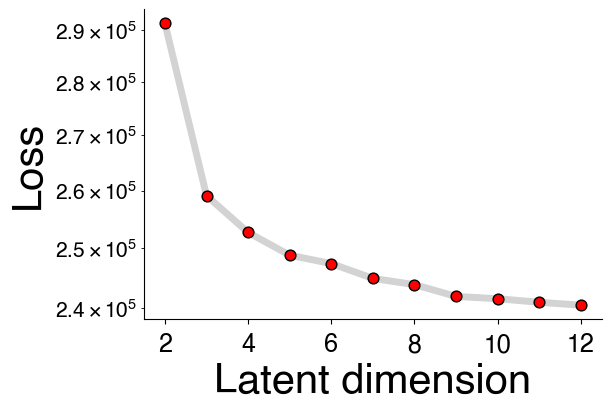

In [11]:
# Plot final losses by model
if "losses" in posteriors[latent_dim_candidates[0]].samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    
    losses = {dim: post.samples["losses"][-1] for dim, post in posteriors.items()}
    ax.plot(losses.keys(), losses.values(), zorder=-1, color="lightgrey")
    ax.scatter(losses.keys(), losses.values(), ec="k", s=60, color="red")
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Latent dimension")
    ax.set_xticks([2,4,6, 8, 10, 12])
    
#    fig.savefig("../manuscript/supplementary_figures/loss_by_latent_dimension.png")

In [12]:
chosen_latent = 8
posterior = posteriors[chosen_latent]

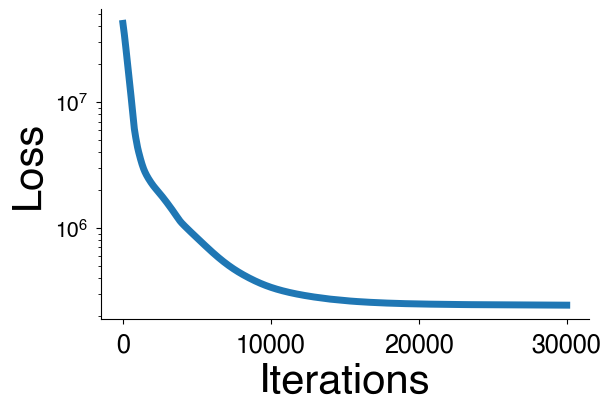

In [13]:
if "losses" in posterior.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [14]:
def get_groups(samples, sites, group):
    samples_group = dict()
    for site in sites:
        samples_group[site] = samples[site][..., group] 
    return samples_group

def get_posterior(posterior, sites, group):
    _samples = get_groups(posterior.samples, sites, group)
    _data = posterior.data.groups[group]
    return ef.PosteriorHandler(samples=_samples, data=_data)

In [15]:
eta = np.array(posterior.samples["eta"][0,:,:])

In [16]:
posterior.data.var_names

['B.1.1.529',
 'BA.2.86.1',
 'BA.5.2',
 'BA.5.2.1',
 'BN.1',
 'BQ.1.1',
 'CH.1.1',
 'CH.1.1.1',
 'EG.1',
 'EG.5.1',
 'EG.5.1.1',
 'EG.5.1.3',
 'EG.5.1.4',
 'EG.5.1.6',
 'FL.1.5.1',
 'FL.2',
 'FL.4',
 'FU.1',
 'GE.1',
 'GJ.1.2',
 'GK.1.1',
 'HF.1',
 'HK.3',
 'HK.3.2',
 'HV.1',
 'JD.1.1',
 'JG.3',
 'JN.1',
 'JN.1.1',
 'JN.1.11.1',
 'JN.1.4',
 'JN.1.4.5',
 'JN.1.7',
 'JN.1.8',
 'KP.2',
 'KP.3',
 'XBB.1',
 'XBB.1.16',
 'XBB.1.16.1',
 'XBB.1.16.11',
 'XBB.1.16.6',
 'XBB.1.18.1',
 'XBB.1.22.1',
 'XBB.1.5',
 'XBB.1.5.15',
 'XBB.1.5.70',
 'XBB.1.9.1',
 'XBB.1.9.2',
 'XBB.2.3',
 'XBB.2.3.11',
 'XBB.2.3.2',
 'XBC.1',
 'other']

In [17]:
eta.shape

(53, 8)

In [18]:
import pandas as pd
import numpy as np

def eta_to_dataframe(eta, variant_names):
    num_latent_dims = eta.shape[1]
    latent_columns = [f"latent_dim_{i}" for i in range(num_latent_dims)]
    df = pd.DataFrame(eta, columns=latent_columns)
    df["variant"] = variant_names
    return df

eta_df = eta_to_dataframe(eta, posterior.data.var_names)

In [19]:
eta_df

,latent_dim_0,latent_dim_1,latent_dim_2,latent_dim_3,latent_dim_4,latent_dim_5,latent_dim_6,latent_dim_7,variant
0,-0.264114,0.051311,0.301251,-0.010300,-0.140921,0.364595,-0.475436,0.120568,B.1.1.529
1,-0.123862,0.037785,0.010334,0.045507,-0.743670,0.602311,0.217480,-0.585298,BA.2.86.1
2,0.556216,-0.782424,0.925011,0.009155,0.702423,-0.731691,-0.131359,-0.636951,BA.5.2
3,0.617191,-0.841972,0.696769,-0.280324,0.553800,-0.666162,0.176200,-0.542861,BA.5.2.1
4,-0.188060,-0.083560,0.674823,-0.192102,-0.066965,0.178607,-0.519228,0.041063,BN.1
5,-0.037440,-0.280874,0.196042,0.150199,-0.064273,0.204917,-0.312951,0.087536,BQ.1.1
6,0.050980,-0.637995,0.872047,0.207282,-0.296548,-0.383286,-0.248979,0.224355,CH.1.1
7,0.053918,-0.572638,-0.298228,0.515262,0.073904,0.463417,-0.066050,0.330464,CH.1.1.1
8,0.050016,-0.564626,0.463628,0.183760,-0.065843,-0.225991,-0.167901,0.506036,EG.1
9,-0.392862,0.039250,0.176619,-0.191570,-0.639117,-0.049681,0.404037,0.213086,EG.5.1


In [20]:
from pango_aliasor.aliasor import Aliasor

antigenic_map = pd.concat([pd.read_csv("../data/antigenic_map_data/immunized human.csv"), 
                           pd.read_csv("../data/antigenic_map_data/naive human.csv")])
antigenic_map.columns

# For each variant in posterior, check
# 1. if it was tested directly (ignore)
# 2. its parent was tested (consider renaming)
# 3. its parent is not already directly observed (do not rename)

remapping = {}
aliasor = Aliasor()
for var in posterior.data.var_names:
    parent = aliasor.parent(var)
    if (parent in antigenic_map.columns) and (var not in antigenic_map.columns) and (parent not in posterior.data.var_names):
        remapping[parent] = var

# For each variant in antigenic map, check
# 1. check whether we estimated pseudo-escape for its parent but not directly
# 2. check whether parent is directly observed (do not rename)
# 3. That we have not already renamed
# 4. Avoid long brannches -> avoid collapsing BA.1, BA.2, BA.5

for var in antigenic_map.columns:
    parent = aliasor.parent(var)
    if ((parent in posterior.data.var_names) 
        and (var not in posterior.data.var_names) 
        and (parent not in antigenic_map.columns)
        and (var not in remapping)
        and (parent not in ["B.1.1.529"])
       ):
        remapping[var] = parent

        
antigenic_map = antigenic_map.rename(columns=remapping) 

In [21]:
antigenic_map

,id,group,D614G,Beta,BA.1,BA.2,BA.2.75,CH.1.1,BA.5.2,BA.5.2.1,...,EG.5.1,HV.1,HK.3,JD.1.1,JG.3,BA.2.86.1,JN.1,BA.2.87.1,JN.1.23,KP.3
0,JN.1-36,BA.5/BF.7 BTI + JN.1 infection,1381,714,2235,8310,2671,559,4119,2680,...,327,475,250,170,245,1072,939,195,461,399
1,JN.1-49,BA.5/BF.7 BTI + JN.1 infection,463,671,1042,829,537,135,2103,544,...,271,445,365,321,200,735,284,107,257,146
2,JN.1-2,BA.5/BF.7 BTI + JN.1 infection,4862,1122,2805,7525,374,300,3650,2455,...,485,587,283,175,294,1410,866,455,411,252
3,JN.1-5,BA.5/BF.7 BTI + JN.1 infection,310,256,1425,2028,511,273,3710,1799,...,480,655,243,135,153,801,771,151,359,395
4,JN.1-52,BA.5/BF.7 BTI + JN.1 infection,577,568,1220,699,639,82,1047,283,...,203,257,210,173,147,380,259,65,222,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,VAC26,WT vaccine,438,294,114,88,100,20,74,39,...,20,20,20,20,20,31,27,20,28,20
24,BA.5.2-61nv,BA.5 infection,20,20,20,214,44,27,196,104,...,26,44,30,22,23,20,20,20,20,20
25,BA.5.2-60nv,BA.5 infection,20,20,20,146,54,26,190,110,...,42,48,20,20,20,72,62,20,48,20
26,BA.5.2-43nv,BA.5 infection,34,28,30,184,80,33,202,144,...,28,40,26,20,22,86,48,26,34,20


In [22]:
def compute_log2_distances(X):
    X_transformed = np.log2(X.values)
    return np.sqrt(np.sum(np.square(X_transformed.T[..., None] - X_transformed), axis=1))

def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

def get_and_add_distances(post, _distance_df, randomize=False):
    distance_df = _distance_df.copy()
    
    ## Prepping data and labels
    eta = post.samples["eta"][0, :-1, :] # Remove other
    n_vars, n_comps = eta.shape
    
    if randomize:
        perm = np.random.permutation(n_vars)
        eta = eta[perm, :]

    eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
    var_names = post.data.var_names
    var_to_index = {v: i for i, v in enumerate(var_names)}        

    def add_latent_distance(row):
        if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
            return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
        else:
            return np.nan
        
    distance_df["latent_distance"] = distance_df.apply(add_latent_distance, axis=1)
    return distance_df

X = antigenic_map.drop(columns=["id", "group"])
common_variants = [v for v in posterior.data.var_names if v in X.columns]
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)
distances_df = get_and_add_distances(posteriors[chosen_latent], distances_df)
distances_df = distances_df[distances_df.variant_1 != distances_df.variant_2]

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

def extract_titer_matrix(antigenic_map, variant_columns):
    """
    Extract the matrix of titers and corresponding metadata.
    
    Returns:
    - titer_matrix: np.ndarray
    - metadata: pd.DataFrame with ['id', 'group']
    """
    titer_matrix = np.log2(antigenic_map[variant_columns].values)
    metadata = antigenic_map[['id', 'group']]
    return titer_matrix, metadata

def run_pca(titer_matrix, n_components=2):
    """
    Perform PCA on the titer matrix.
    
    Returns:
    - pca: trained PCA object
    - pcs: array of shape (n_samples, n_components)
    - explained_variance: list of variance explained per component
    """
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(titer_matrix)
    explained_variance = pca.explained_variance_ratio_
    return pca, pcs, explained_variance

def plot_pca(pcs, metadata, explained_variance, ax=None, title="log2(titers)"):
    """
    Plot PCA results with group coloring and labeled axes using pastel colors.
    """
    df_plot = metadata.copy()
    df_plot['PC1'] = pcs[:, 0]
    df_plot['PC2'] = pcs[:, 1]

    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        gs = gridspec.GridSpec(1, 1)
        ax = fig.add_subplot(gs[0])

    # Use Seaborn pastel palette
    unique_groups = df_plot['group'].unique()
    palette = sns.color_palette('tab10', n_colors=len(unique_groups))

    sns.scatterplot(
        data=df_plot,
        x='PC1',
        y='PC2',
        hue='group',
        palette=palette,
        s=80,
        ax=ax,
        edgecolor='k',  # optional: makes points stand out
        linewidth=0.5
    )

    ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}% variance)")
    ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}% variance)")
    ax.set_title(title)
    ax.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')

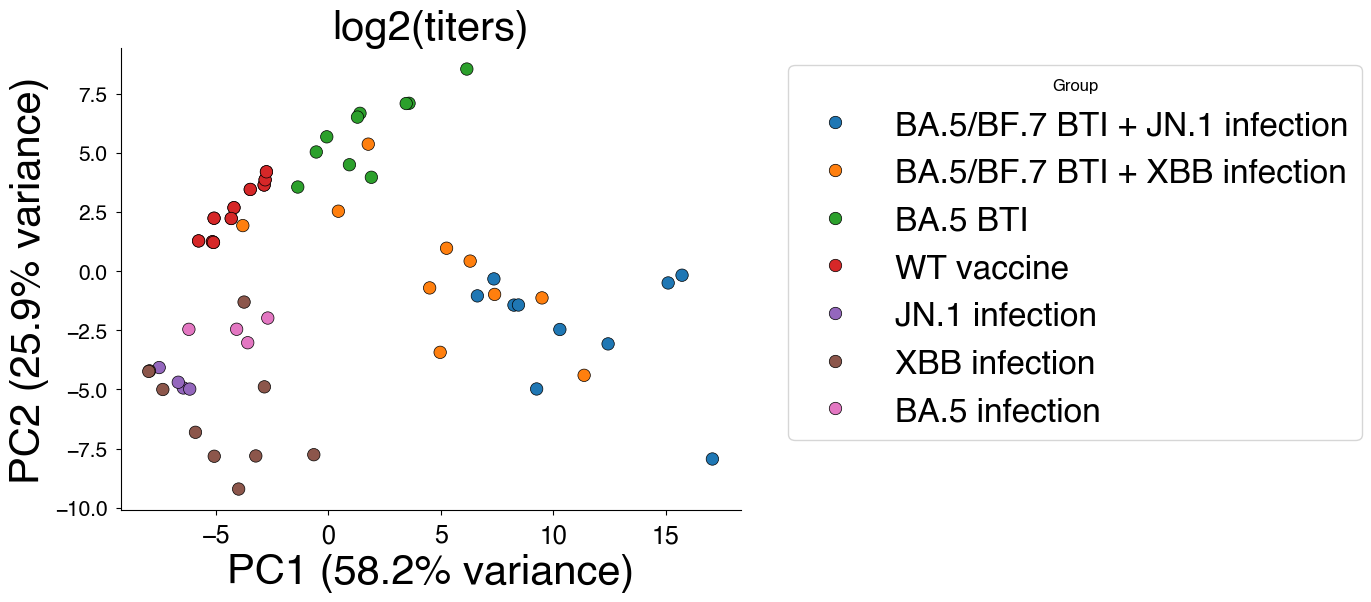

In [24]:
# Assume antigenic_map is already loaded as a DataFrame
variant_columns = [col for col in antigenic_map.columns if col not in ["id", "group"]]

titer_matrix, metadata = extract_titer_matrix(antigenic_map, variant_columns)
pca, pcs, explained_variance = run_pca(titer_matrix)
plot_pca(pcs, metadata, explained_variance)

In [25]:
def compute_log2_group_mean_titers(df, variant_names, group_col="group"):
    """
    Returns a DataFrame: rows = variants, cols = groups, values = log2(mean titer + 1)
    """
    variant_columns = [v for v in variant_names if v in df.columns]
    grouped = df.groupby(group_col)[variant_columns].mean()
    log2_group_means = np.log2(grouped + 1.).T  # transpose: now rows = variants
    log2_group_means.index.name = "variant"
    return log2_group_means

def compute_group_counts_matrix(df, variant_names, group_col="group"):
    """
    Returns a DataFrame: rows = variants, cols = groups, values = # of non-NaN individuals
    contributing to each (variant, group) mean. This aligns with compute_log2_group_mean_titers.
    """
    variant_columns = [v for v in variant_names if v in df.columns]
    if not variant_columns:
        raise ValueError("None of the provided variant_names are columns in df.")
    # Count non-missing values per group, then align/transpose to (variants x groups)
    counts = df.groupby(group_col, observed=True)[variant_columns].count()
    counts = counts.T
    counts.index.name = "variant"
    return counts

def align_eta_to_group_means(eta, variant_names, group_mean_df):
    """
    Aligns eta to the rows (variants) present in the group mean matrix.
    Returns:
    - eta_aligned: array (num_variants, latent_dim)
    - group_means: array (num_variants, num_groups)
    - groups: list of group names
    """
    common_variants = group_mean_df.index
    variant_indices = [variant_names.index(v) for v in common_variants]
    eta_aligned = eta[variant_indices]
    group_means = group_mean_df.values  # shape: (variants, groups)
    groups = group_mean_df.columns.tolist()
    return eta_aligned, group_means, groups

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fit_groupwise_regression(eta_aligned, group_mean_matrix, group_names):
    """
    Fits a linear regression model for each group: mean log2 titer ~ eta
    Returns:
    - coefficients: dict[group] → coef vector
    - r2_scores: dict[group] → R²
    """
    results = {}
    for i, group in enumerate(group_names):
        y = group_mean_matrix[:, i]
        model = LinearRegression().fit(eta_aligned, y)
        r2 = r2_score(y, model.predict(eta_aligned))
        results[group] = {
            "coef": model.coef_,
            "intercept": model.intercept_,
            "r2": r2
        }
    return results

def fit_groupwise_regression(eta_aligned, group_mean_matrix, group_names, weights_matrix=None):
    """
    Fits a linear regression model for each group: mean log2 titer ~ eta
    Optional weighting: if weights_matrix is provided (same shape as group_mean_matrix),
    each variant's contribution is weighted by the number of individuals in that (variant, group).

    Returns:
    - results: dict[group] -> {"coef": array, "intercept": float, "r2": float, "n_used": int}
    """
    results = {}
    V, G = group_mean_matrix.shape
    if weights_matrix is not None:
        if weights_matrix.shape != group_mean_matrix.shape:
            raise ValueError("weights_matrix must have the same shape as group_mean_matrix.")
        W = np.asarray(weights_matrix, dtype=float)
    else:
        W = None

    for i, group in enumerate(group_names):
        y = group_mean_matrix[:, i]
        # mask out missing means or zero weight rows
        if W is not None:
            w = W[:, i]
            mask = np.isfinite(y) & (w > 0)
        else:
            mask = np.isfinite(y)
            w = None

        if mask.sum() < 2:
            results[group] = {"coef": np.full(eta_aligned.shape[1], np.nan),
                              "intercept": np.nan, "r2": np.nan, "n_used": int(mask.sum())}
            continue

        X = eta_aligned[mask]
        y_fit = y[mask]
        if w is not None:
            w_fit = w[mask]
            model = LinearRegression().fit(X, y_fit, sample_weight=w_fit)
            y_pred = model.predict(X)
            # weighted R^2 with weighted mean
            wsum = w_fit.sum()
            ybar = np.sum(w_fit * y_fit) / wsum
            sst = np.sum(w_fit * (y_fit - ybar)**2)
            sse = np.sum(w_fit * (y_fit - y_pred)**2)
            r2 = np.nan if sst <= 0 else 1.0 - sse / sst
        else:
            model = LinearRegression().fit(X, y_fit)
            r2 = r2_score(y_fit, model.predict(X))

        results[group] = {
            "coef": model.coef_,
            "intercept": float(model.intercept_),
            "r2": float(r2),
            "n_used": int(mask.sum())
        }
    return results

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_groupwise_eta_interpretation(results):
    """
    - Heatmap of group coefficients (group × eta_dim)
    - Bar plot of R² scores per group
    """
    groups = list(results.keys())
    coefs = np.array([results[g]["coef"] for g in groups])
    r2s = [results[g]["r2"] for g in groups]

    fig = plt.figure(figsize=(12, 13))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # --- Top: Heatmap of coefficients ---
    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(
        coefs,
        cmap="vlag",
        center=0,
        xticklabels=[f"η_{i}" for i in range(coefs.shape[1])],
        yticklabels=groups,
        cbar_kws={"label": "Coefficient (log₂ mean titer ~ η)"},
        ax=ax1
    )
    ax1.set_title("Group-Level η Dimension Coefficients")
    ax1.set_xlabel("Latent η Dimension")
    ax1.set_ylabel("Group")

    # --- Bottom: R² per group ---
    ax2 = fig.add_subplot(gs[1])
    pastel_palette = sns.color_palette("pastel", len(groups))
    ax2.bar(groups, r2s, color=pastel_palette, edgecolor='k')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("R²")
    ax2.set_title("Explained Variance (R²) of Group Mean Titers")
    ax2.set_xticklabels(groups, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1731/2386129612.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(groups, rotation=45, ha='right')


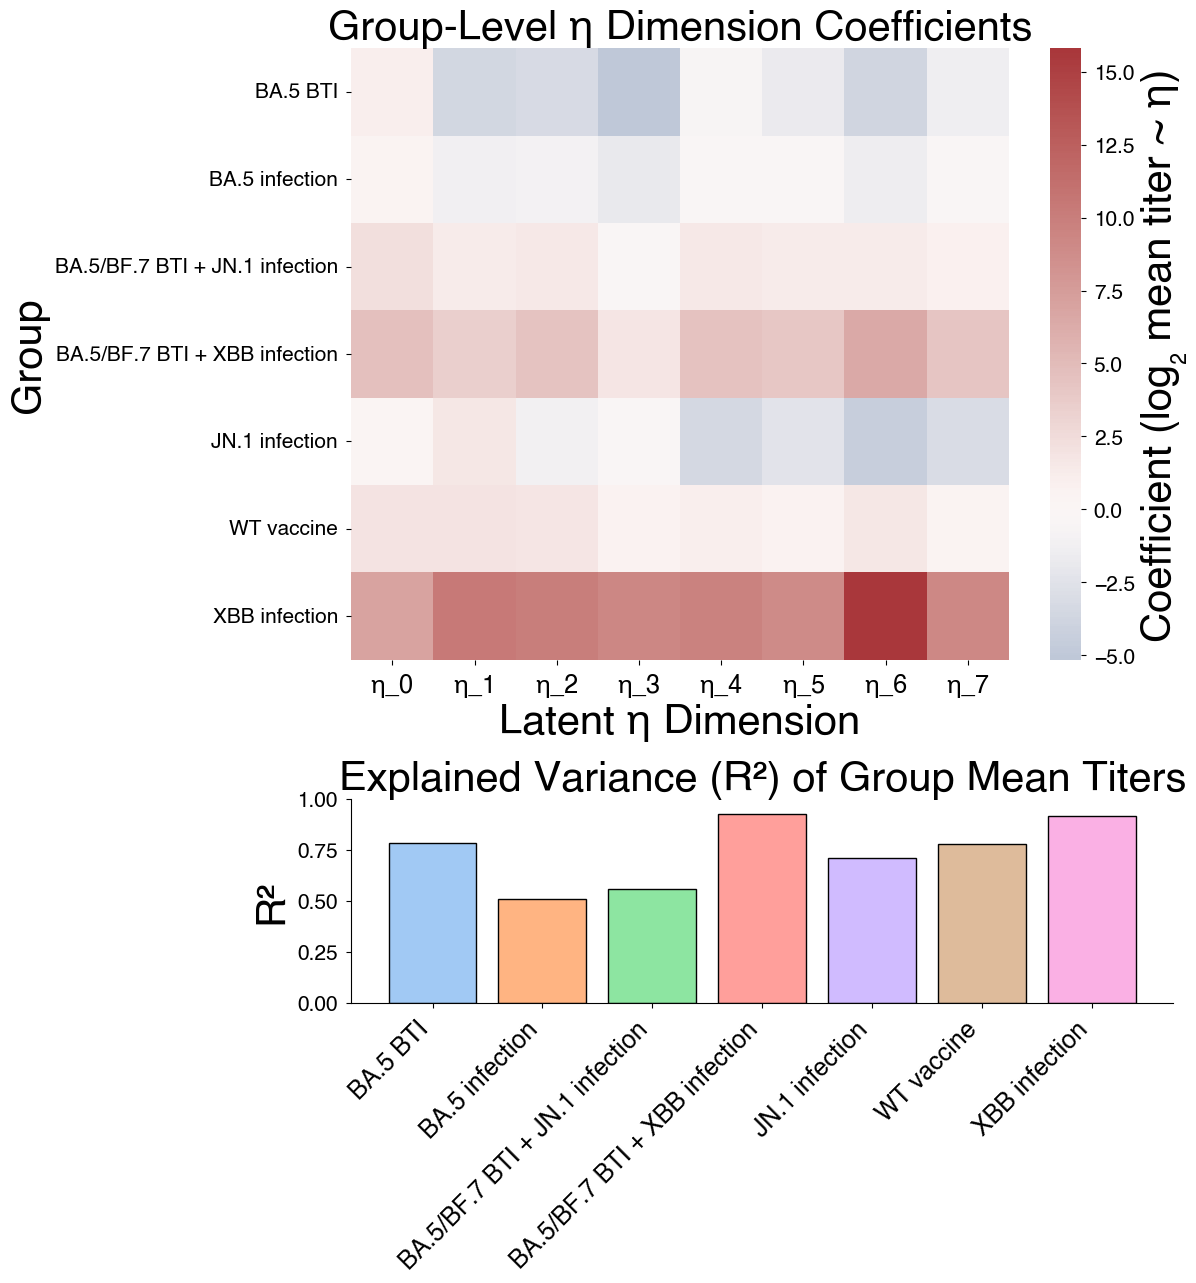

In [26]:
# Compute log2 mean titers
variant_names = posterior.data.var_names
group_mean_df = compute_log2_group_mean_titers(antigenic_map, variant_names, group_col="group")
counts_df      = compute_group_counts_matrix(antigenic_map, variant_names, group_col="group")

# Align with eta
eta_aligned, group_mean_matrix, group_names = align_eta_to_group_means(eta, variant_names, group_mean_df)

# Fit regressions
results = fit_groupwise_regression(eta_aligned, group_mean_matrix, group_names, weights_matrix=counts_df.values)

# Visualize
plot_groupwise_eta_interpretation(results)

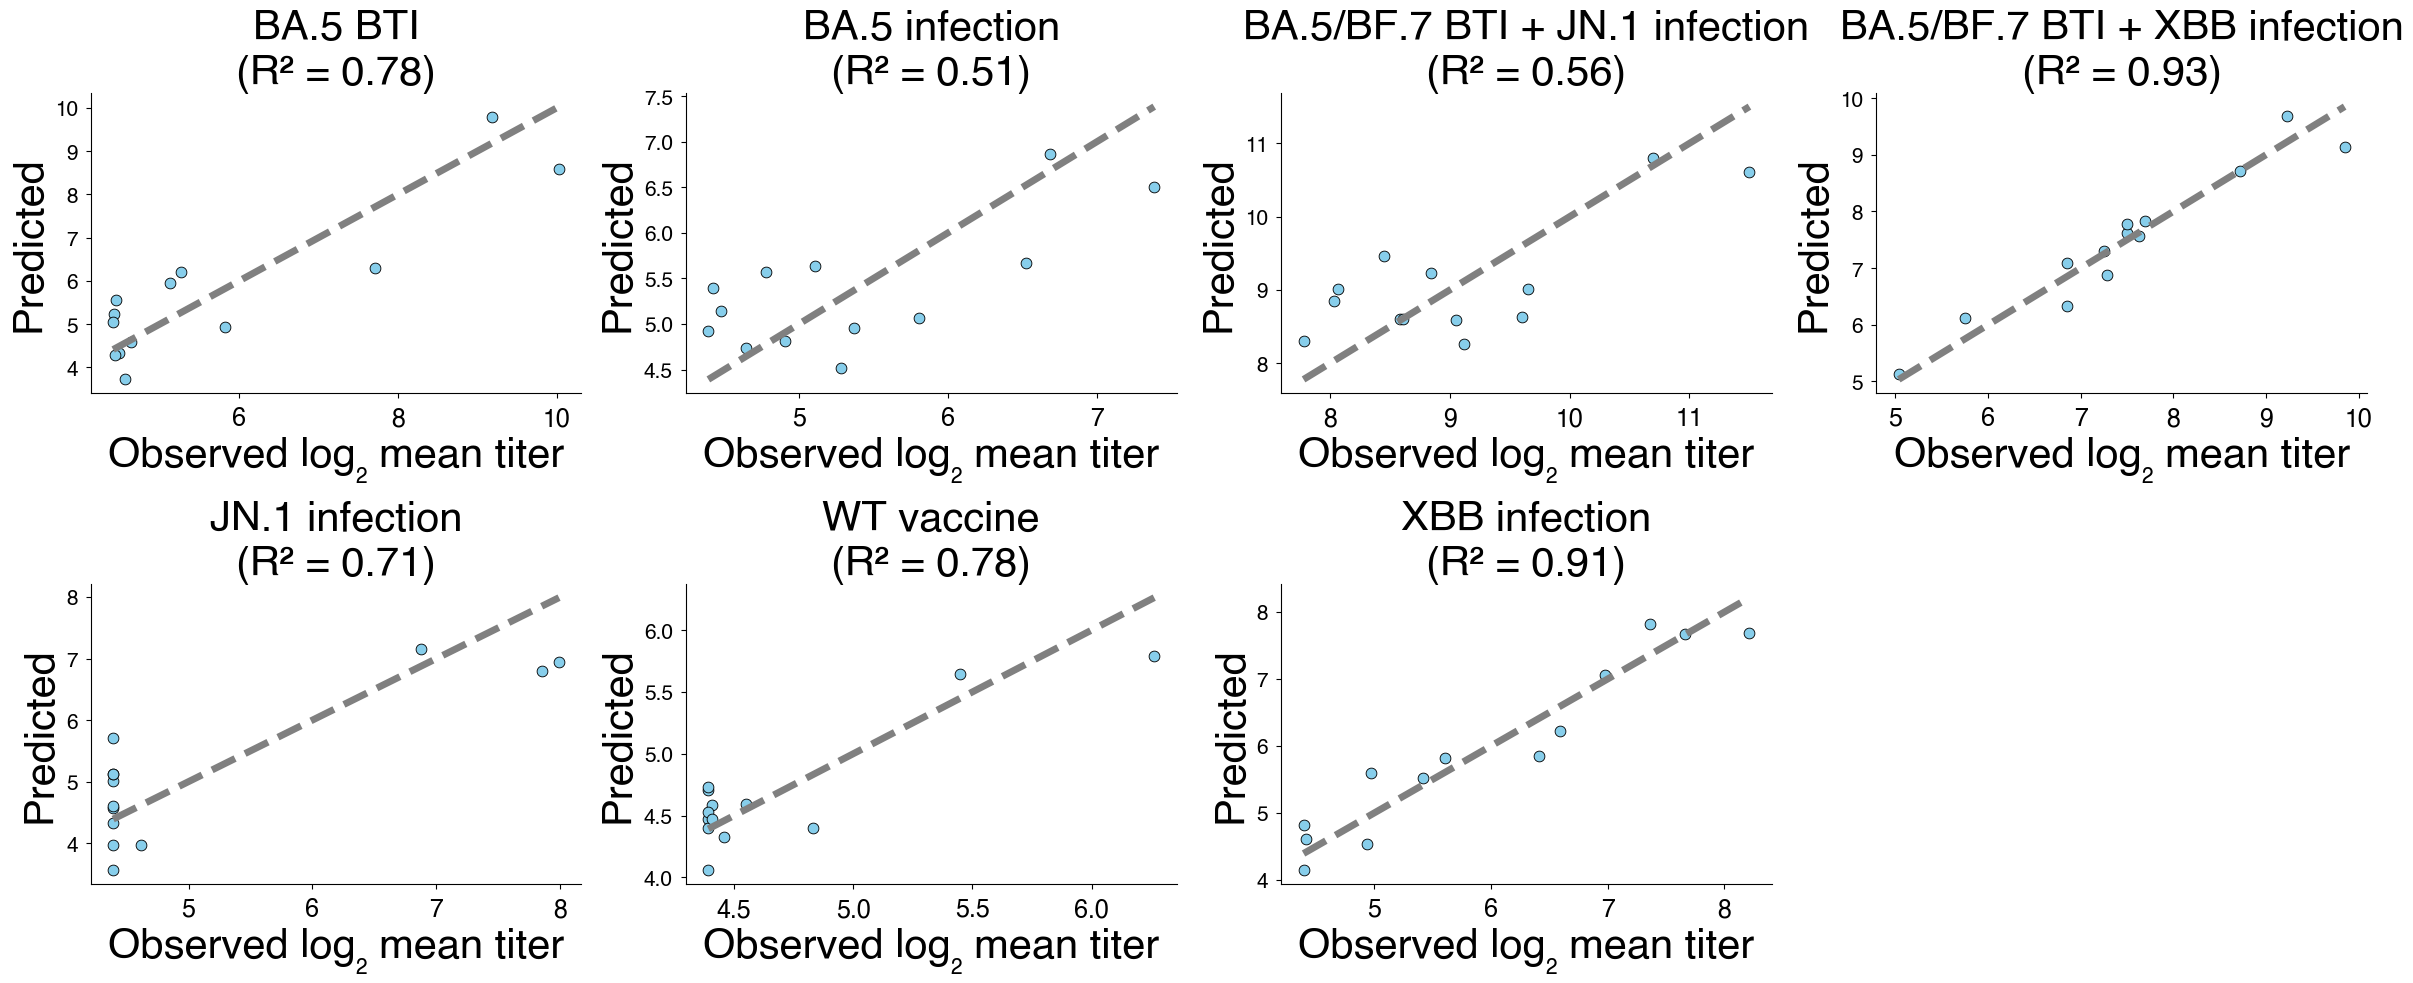

In [27]:
def plot_groupwise_pred_vs_actual(results, eta_aligned, group_mean_matrix, group_names):
    """
    Small multiples of actual vs predicted log2 mean titers per group.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    n_groups = len(group_names)
    ncols = 4
    nrows = math.ceil(n_groups / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)

    for idx, group in enumerate(group_names):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]

        y_true = group_mean_matrix[:, idx]
        model = results[group]
        y_pred = eta_aligned @ model["coef"] + model["intercept"]

        sns.scatterplot(x=y_true, y=y_pred, ax=ax, color="skyblue", edgecolor="k", s=60)
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray')
        ax.set_title(f"{group}\n(R² = {model['r2']:.2f})")
        ax.set_xlabel("Observed log₂ mean titer")
        ax.set_ylabel("Predicted")

    # Turn off unused subplots
    for i in range(n_groups, nrows * ncols):
        row, col = divmod(i, ncols)
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_groupwise_pred_vs_actual(results, eta_aligned, group_mean_matrix, group_names)

In [28]:
group_mean_df

group,BA.5 BTI,BA.5 infection,BA.5/BF.7 BTI + JN.1 infection,BA.5/BF.7 BTI + XBB infection,JN.1 infection,WT vaccine,XBB infection
variant,,,,,,,
BA.2.86.1,5.817623,5.807355,9.605665,6.850499,7.988685,4.832890,4.412782
BA.5.2,10.025278,7.383704,11.503229,9.849092,4.392317,6.263034,5.608809
BA.5.2.1,9.185619,6.686501,10.700613,9.228578,4.392317,5.446256,5.412782
BQ.1.1,7.706669,6.523562,9.652128,7.626439,4.392317,4.459432,4.968091
CH.1.1,5.125155,4.781360,8.033423,7.255501,4.392317,4.405992,4.940167
EG.5.1,4.638074,4.906891,8.584211,7.693487,4.392317,4.392317,7.663202
HK.3,4.491853,4.643856,8.605480,7.497453,4.392317,4.392317,7.361944
HV.1,4.560715,5.285402,9.114783,7.284477,4.614710,4.392317,6.977280
JD.1.1,4.446256,4.426265,8.446670,7.497453,4.392317,4.392317,6.586465


In [29]:
def compute_eta_vs_mean_titer_correlations(df, eta, variant_names):
    """
    For each η dimension, compute the correlation between η[:, i] and mean log2 titer to each variant.
    Returns a DataFrame: rows = η dims, cols = group names (or 'all')
    """
    variant_columns = [v for v in variant_names if v in df.columns]
    variant_indices = [variant_names.index(v) for v in variant_columns]

    eta_aligned = eta[variant_indices]
    variant_names_used = [variant_names[i] for i in variant_indices]

    # Mean titer across all individuals (or per group if desired)
    titer_matrix = df[variant_columns]
    mean_titers = np.log2(titer_matrix + 1).mean(axis=0).values  # shape: (num_variants_used,)

    corrs = []
    for dim in range(eta_aligned.shape[1]):
        corr = np.corrcoef(eta_aligned[:, dim], mean_titers)[0, 1]
        corrs.append(corr)

    return pd.DataFrame([corrs], index=["all"], columns=[f"η_{i}" for i in range(eta.shape[1])])

In [30]:
def compute_eta_vs_group_mean_titer_correlations(df, eta, variant_names):
    """
    Correlate η[:, i] with group-mean log2 titers across variants.
    Returns a DataFrame: rows = groups, cols = η dims
    """
    variant_columns = [v for v in variant_names if v in df.columns]
    variant_indices = [variant_names.index(v) for v in variant_columns]
    eta_aligned = eta[variant_indices]
    group_means = np.log2(df.groupby("group")[variant_columns].mean() + 1)  # shape: (group, variant)

    corrs = []
    for group in group_means.index:
        group_titers = group_means.loc[group].values  # shape: (num_variants,)
        dim_corrs = [
            np.corrcoef(eta_aligned[:, i], group_titers)[0, 1]
            for i in range(eta.shape[1])
        ]
        corrs.append(dim_corrs)

    return pd.DataFrame(corrs, index=group_means.index, columns=[f"η_{i+1}" for i in range(eta.shape[1])])

In [31]:
def plot_eta_vs_titer_correlation_heatmap(corr_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 1.5*max(1.5, 0.5 * len(corr_df))))
    sns.heatmap(
        corr_df,
        center=0,
        cmap="vlag",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Pearson r"},
    )
    plt.xlabel("Latent η Dimension")
    plt.ylabel("Group")
    plt.title("Correlation between η and Group-Mean log₂ Titer")
    plt.tight_layout()
    plt.show()

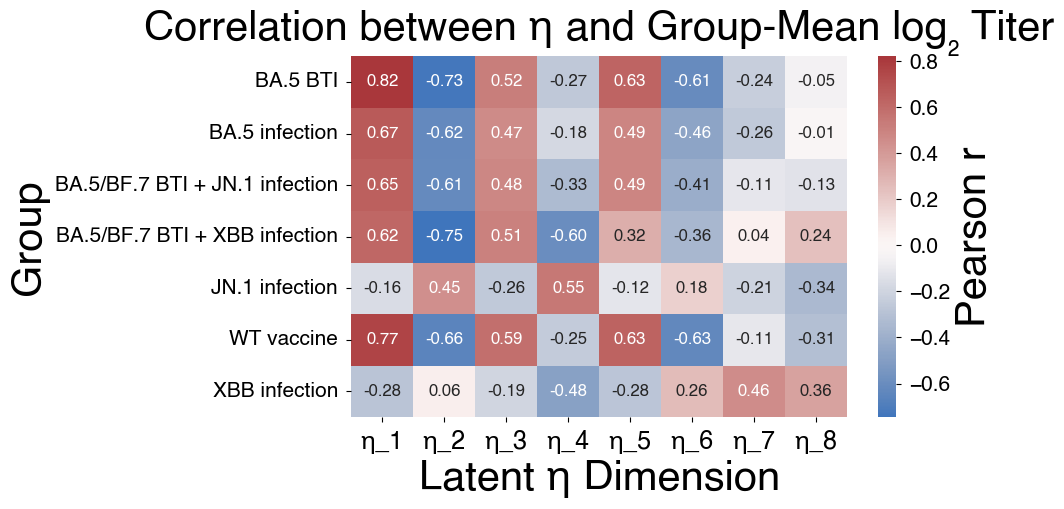

In [32]:
corr_df = compute_eta_vs_group_mean_titer_correlations(antigenic_map, eta, variant_names)
plot_eta_vs_titer_correlation_heatmap(corr_df)

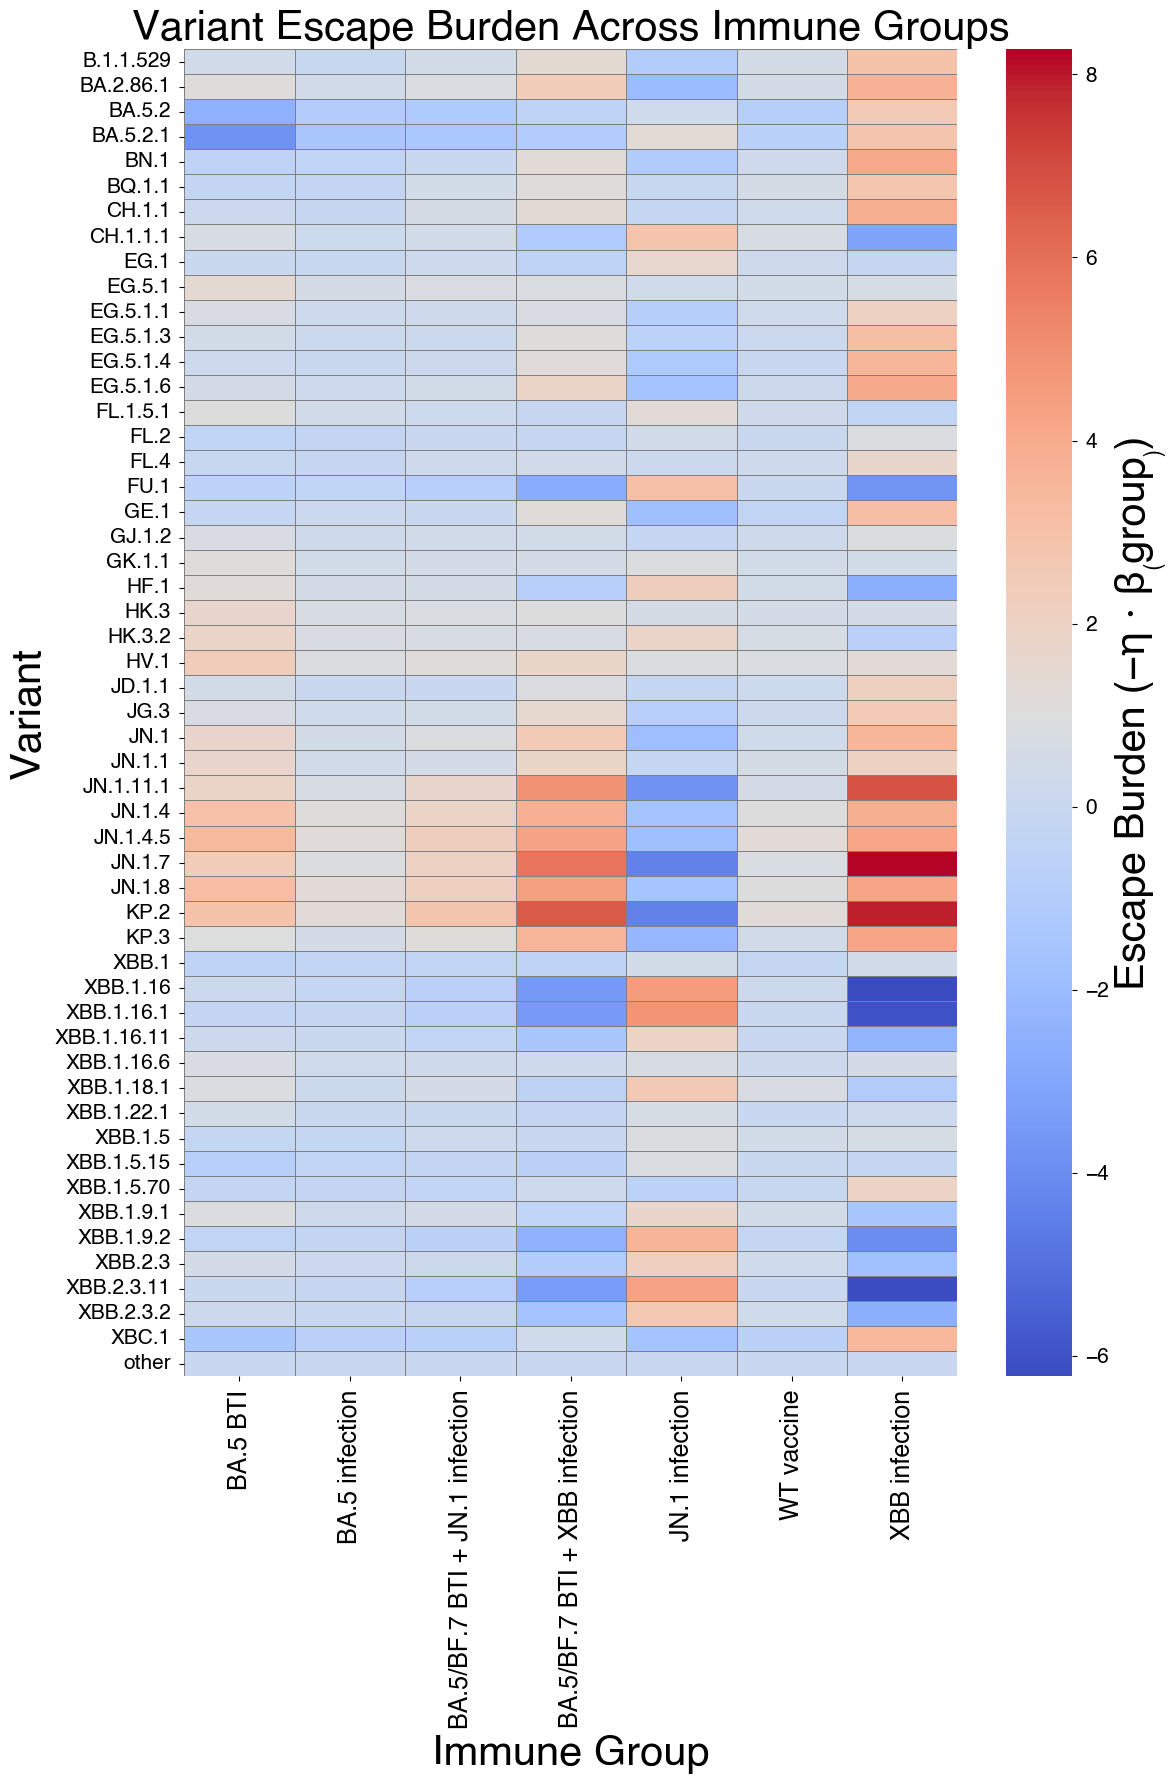

In [33]:
def compute_escape_burden(eta, variant_names, results):
    """
    Compute escape burden for each group and variant:
    EscapeBurden[v, g] = - η[v] ⋅ β_g
    Returns:
    - burden_df: DataFrame (variants × groups)
    """
    group_names = list(results.keys())
    burden = []

    for group in group_names:
        beta_g = results[group]["coef"]
        burden_g = -eta @ beta_g  # shape: (num_variants,)
        burden.append(burden_g)

    burden_array = np.stack(burden, axis=1)  # shape: (variants, groups)
    burden_df = pd.DataFrame(burden_array, index=variant_names, columns=group_names)

    return burden_df

def plot_escape_burden_heatmap(burden_df, figsize=(12, 18)):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    sns.heatmap(
        burden_df,
        cmap="coolwarm",
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={"label": "Escape Burden (−η · β₍group₎)"},
    )
    plt.title("Variant Escape Burden Across Immune Groups")
    plt.xlabel("Immune Group")
    plt.ylabel("Variant")
    plt.tight_layout()
    plt.show()
    
burden_df = compute_escape_burden(eta, variant_names, results)
plot_escape_burden_heatmap(burden_df)

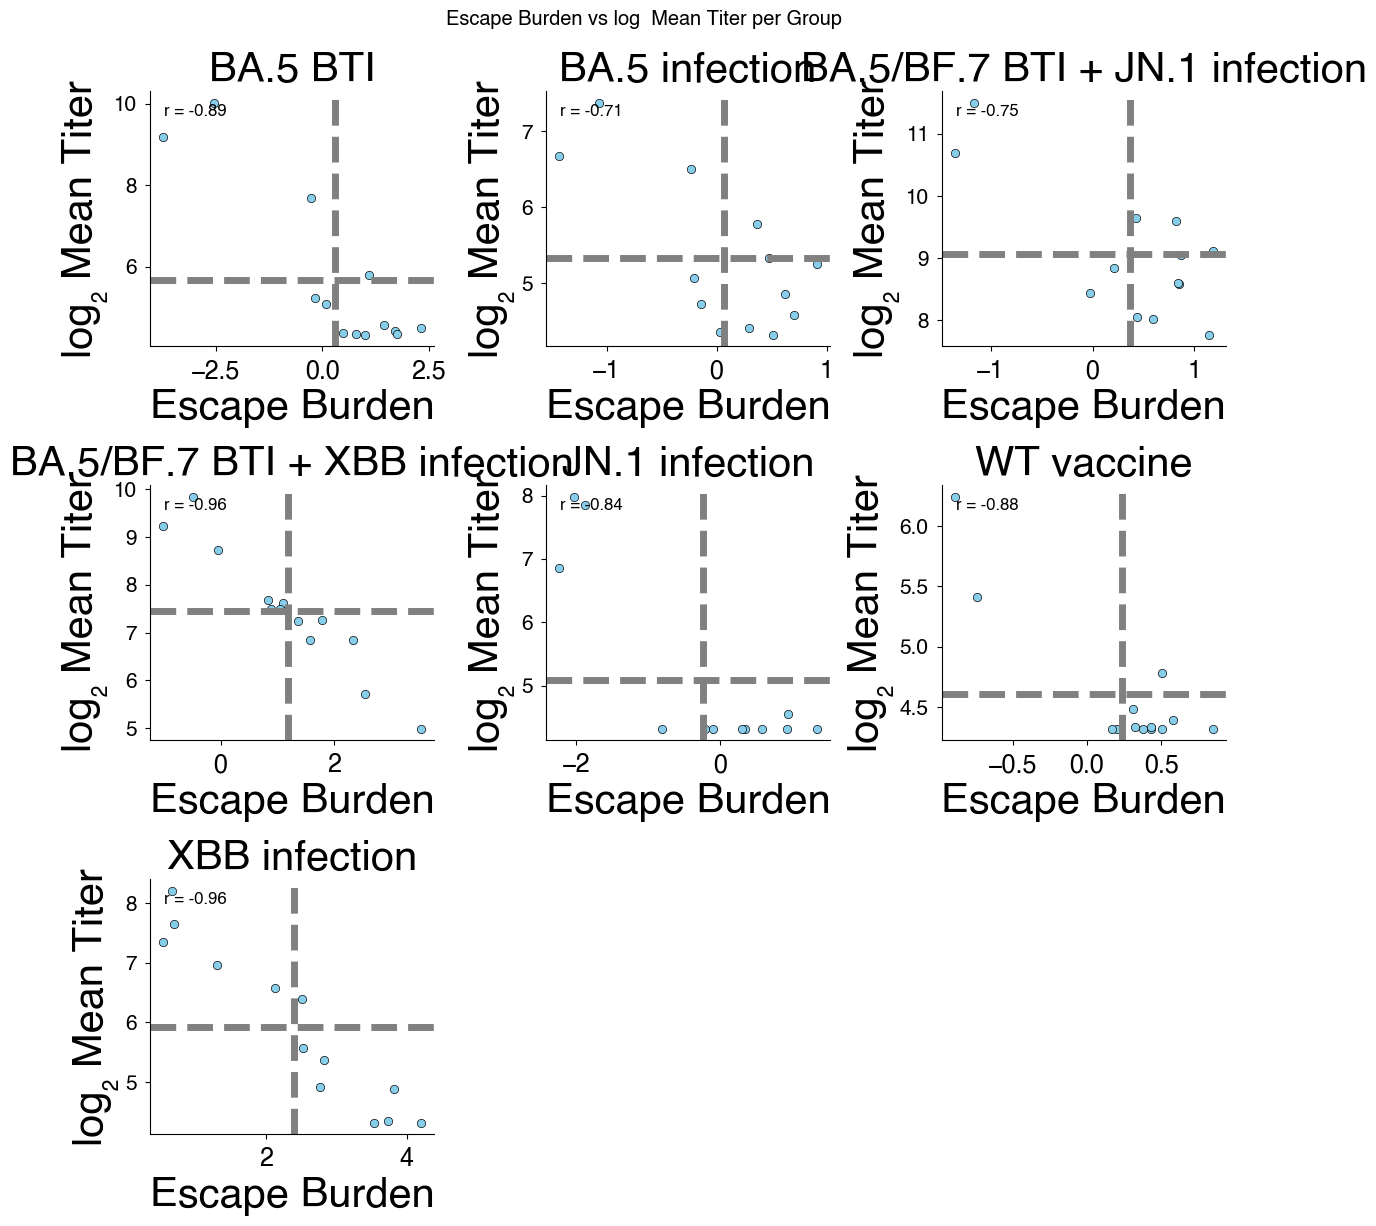

In [34]:
def plot_escape_burden_vs_log2_titer(
    antigenic_map, burden_df, variant_names, group_names, figsize=(4 * 3, 4 * 3)
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import math

    # Compute group mean log2 titers
    variant_columns = [v for v in variant_names if v in antigenic_map.columns]
    group_titer_means = (
        np.log2(antigenic_map.groupby("group")[variant_columns].mean())
        .T.reindex(columns=group_names)
    )

    n_groups = len(group_names)
    ncols = 3
    nrows = math.ceil(n_groups / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, group in enumerate(group_names):
        row, col = divmod(i, ncols)
        ax = axes[row][col]
        y = group_titer_means[group].values
        x = burden_df[burden_df.index.isin(variant_columns)][group].values
        sns.scatterplot(x=x, y=y, ax=ax, color="skyblue", edgecolor="k")
        ax.set_title(f"{group}")
        ax.set_xlabel("Escape Burden")
        ax.set_ylabel("log₂ Mean Titer")
        ax.axhline(y.mean(), color="gray", linestyle="--")
        ax.axvline(x.mean(), color="gray", linestyle="--")

        # Add Pearson r
        r = np.corrcoef(x, y)[0, 1]
        ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, ha="left", va="top")

    for j in range(i + 1, nrows * ncols):
        row, col = divmod(j, ncols)
        axes[row][col].axis("off")

    plt.tight_layout()
    plt.suptitle("Escape Burden vs log₂ Mean Titer per Group", y=1.02)
    plt.show()
    
plot_escape_burden_vs_log2_titer(
    antigenic_map, burden_df, variant_names, group_names, figsize=(4 * 3, 4 * 3)
)

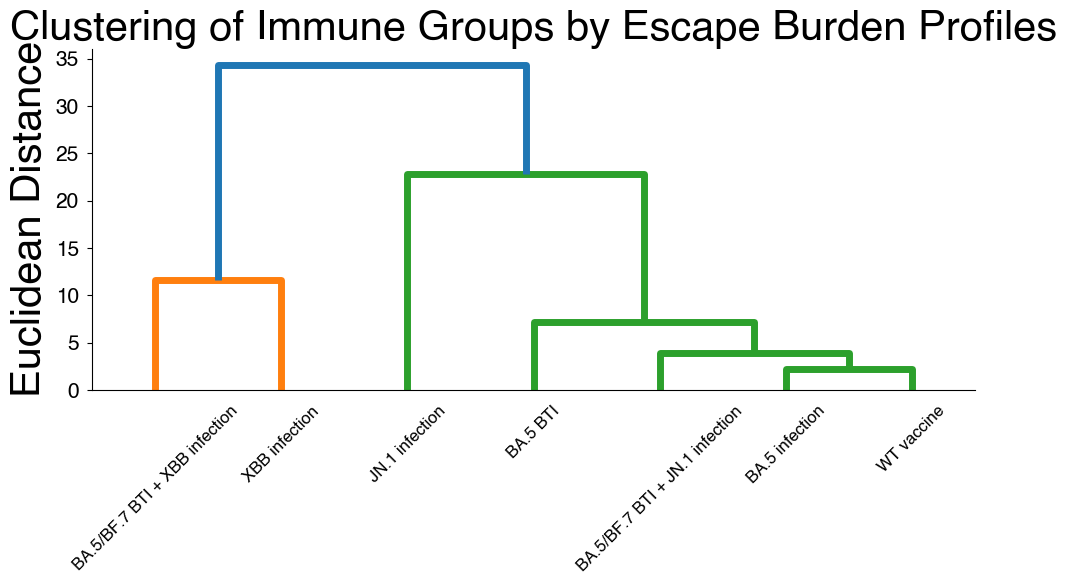

In [35]:
def plot_group_clustering_by_escape_burden(burden_df):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import linkage, dendrogram
    from scipy.spatial.distance import pdist

    group_matrix = burden_df.T.values  # shape: (groups, variants)
    group_names = burden_df.columns

    # Compute hierarchical clustering
    dist = pdist(group_matrix, metric="euclidean")
    linkage_matrix = linkage(dist, method="ward")

    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=group_names, orientation="top", leaf_rotation=45)
    plt.title("Clustering of Immune Groups by Escape Burden Profiles")
    plt.ylabel("Euclidean Distance")
    plt.tight_layout()
    plt.show()
plot_group_clustering_by_escape_burden(burden_df)

In [36]:
def plot_escape_burden_heatmap(burden_df, figsize=(12, 18), cluster_columns=True):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import linkage, leaves_list
    from scipy.spatial.distance import pdist

    if cluster_columns:
        # Cluster columns (immune groups) using hierarchical clustering
        dist = pdist(burden_df.T.values, metric="euclidean")  # groups x variants
        col_linkage = linkage(dist, method="ward")
        col_order = leaves_list(col_linkage)
        ordered_columns = burden_df.columns[col_order]
        burden_df = burden_df[ordered_columns]

    plt.figure(figsize=figsize)
    sns.heatmap(
        burden_df,
        cmap="coolwarm",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Escape Burden (−η · β₍group₎)"},
    )
    plt.title("Variant Escape Burden Across Immune Groups (Clustered)" if cluster_columns else "Variant Escape Burden Across Immune Groups")
    plt.xlabel("Immune Group")
    plt.ylabel("Variant")
    plt.tight_layout()
    plt.show()

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist

In [38]:
def cluster_individuals_by_titer(df, variant_names, n_clusters=3):
    """
    Performs PCA and KMeans clustering on log₂ titers.
    Adds a new 'immune_cluster' column to the DataFrame.
    """
    variant_columns = [v for v in variant_names if v in df.columns]
    X = np.log2(df[variant_columns] + 1).fillna(0).values

    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_pca)
    df = df.copy()
    df["immune_cluster"] = [f"cluster_{i}" for i in kmeans.labels_]

    return df, pca, kmeans

In [39]:
def plot_groupwise_eta_interpretation(results):
    groups = list(results.keys())
    coefs = np.array([results[g]["coef"] for g in groups])
    r2s = [results[g]["r2"] for g in groups]

    fig = plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(2, 1, height_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(coefs, cmap="vlag", center=0,
                xticklabels=[f"η_{i}" for i in range(coefs.shape[1])],
                yticklabels=groups,
                cbar_kws={"label": "Coefficient (log₂ mean titer ~ η)"}, ax=ax1)
    ax1.set_title("Escape Dimension Coefficients per Cluster")
    ax1.set_xlabel("η Dimension")
    ax1.set_ylabel("Cluster")

    ax2 = fig.add_subplot(gs[1])
    pastel_palette = sns.color_palette("pastel", len(groups))
    ax2.bar(groups, r2s, color=pastel_palette, edgecolor='k')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("R²")
    ax2.set_title("Explained Variance (R²) per Cluster")
    ax2.set_xticklabels(groups, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [40]:
def plot_groupwise_pred_vs_actual(results, eta_aligned, group_mean_matrix, group_names):
    import math
    n_groups = len(group_names)
    ncols = 3
    nrows = math.ceil(n_groups / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

    for idx, group in enumerate(group_names):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]

        y_true = group_mean_matrix[:, idx]
        coef = results[group]["coef"]
        intercept = results[group]["intercept"]
        y_pred = eta_aligned @ coef + intercept

        sns.scatterplot(x=y_true, y=y_pred, ax=ax, color="skyblue", edgecolor="k", s=60)
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray')
        ax.set_title(f"{group.replace('cluster_', 'Cluster ')}\n (R² = {results[group]['r2']:.2f})")
        ax.set_xlabel("Actual log₂ mean titer")
        ax.set_ylabel("Predicted")

    for i in range(idx + 1, nrows * ncols):
        row, col = divmod(i, ncols)
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

In [41]:
def compute_escape_burden(eta, variant_names, results):
    group_names = list(results.keys())
    burden = []

    for group in group_names:
        beta_g = results[group]["coef"]
        burden_g = -eta @ beta_g
        burden.append(burden_g)

    burden_array = np.stack(burden, axis=1)
    burden_df = pd.DataFrame(burden_array, index=variant_names, columns=group_names)
    return burden_df

def plot_escape_burden_clustermap(burden_df, figsize=(12, 18), cluster_rows=False):
    cg = sns.clustermap(
        burden_df,
        cmap="coolwarm",
        linewidths=0.5,
        linecolor="gray",
        figsize=figsize,
        cbar_kws={"label": "Escape Burden (−η · β₍group₎)"},
        col_cluster=True,
        row_cluster=cluster_rows,
        xticklabels=True,
        yticklabels=True,
    )
    plt.suptitle("Escape Burden Heatmap with Cluster Dendrogram", y=1.02)
    plt.tight_layout()
    plt.show()

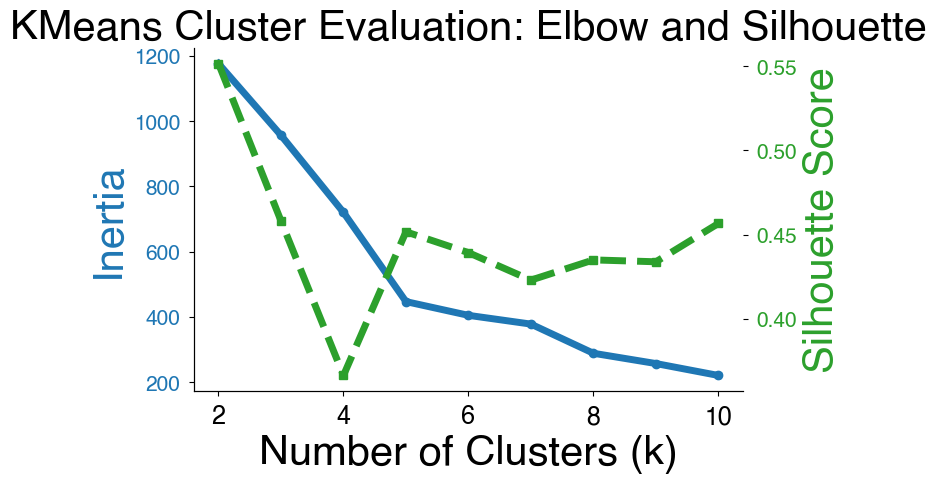

In [42]:
def evaluate_cluster_k_range(df, variant_names, max_k=10):
    """
    Evaluates KMeans clustering with increasing k using PCA of log₂ titers.
    Returns: list of inertias and silhouette scores.
    """
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import numpy as np

    variant_columns = [v for v in variant_names if v in df.columns]
    X = np.log2(df[variant_columns] + 1).fillna(0).values

    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X)

    inertias = []
    silhouettes = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_pca)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_pca, labels))

    return inertias, silhouettes

def plot_cluster_k_selection(inertias, silhouettes, max_k=10):
    import matplotlib.pyplot as plt

    ks = list(range(2, max_k + 1))
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(ks, inertias, 'o-', label='Inertia (Within-cluster SSE)', color='tab:blue')
    ax1.set_xlabel("Number of Clusters (k)")
    ax1.set_ylabel("Inertia", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(ks, silhouettes, 's--', label='Silhouette Score', color='tab:green')
    ax2.set_ylabel("Silhouette Score", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    plt.title("KMeans Cluster Evaluation: Elbow and Silhouette")
    fig.tight_layout()
    plt.show()
    return fig
    
inertias, silhouettes = evaluate_cluster_k_range(antigenic_map, variant_names, max_k=10)
fig_cluster_k = plot_cluster_k_selection(inertias, silhouettes, max_k=10)
fig_cluster_k.savefig("../manuscript/supplementary_figures/clustering_k.png")

In [43]:
# Step 1: Cluster individuals
clustered_df, pca_model, kmeans_model = cluster_individuals_by_titer(antigenic_map, variant_names, n_clusters=5)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1731/1286445979.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(groups, rotation=45, ha='right')


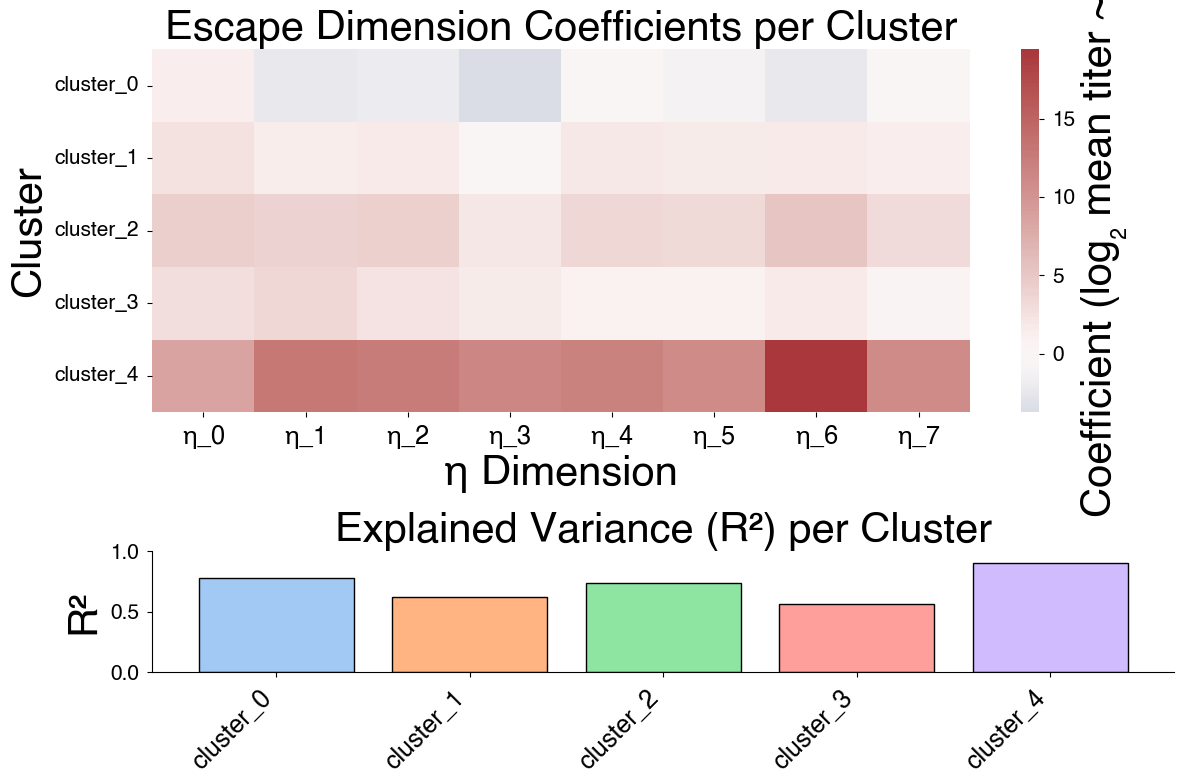

In [44]:
# Step 2: Get cluster mean titers
group_mean_df = compute_log2_group_mean_titers(clustered_df, variant_names, group_col="immune_cluster")
counts_df      = compute_group_counts_matrix(clustered_df, variant_names,  group_col="immune_cluster")

# Step 3: Align eta and fit regressions
eta_aligned, group_mean_matrix, group_names = align_eta_to_group_means(eta, variant_names, group_mean_df)
results = fit_groupwise_regression(eta_aligned, group_mean_matrix, group_names, weights_matrix=counts_df.values)

# Step 4: Visualizations
plot_groupwise_eta_interpretation(results)


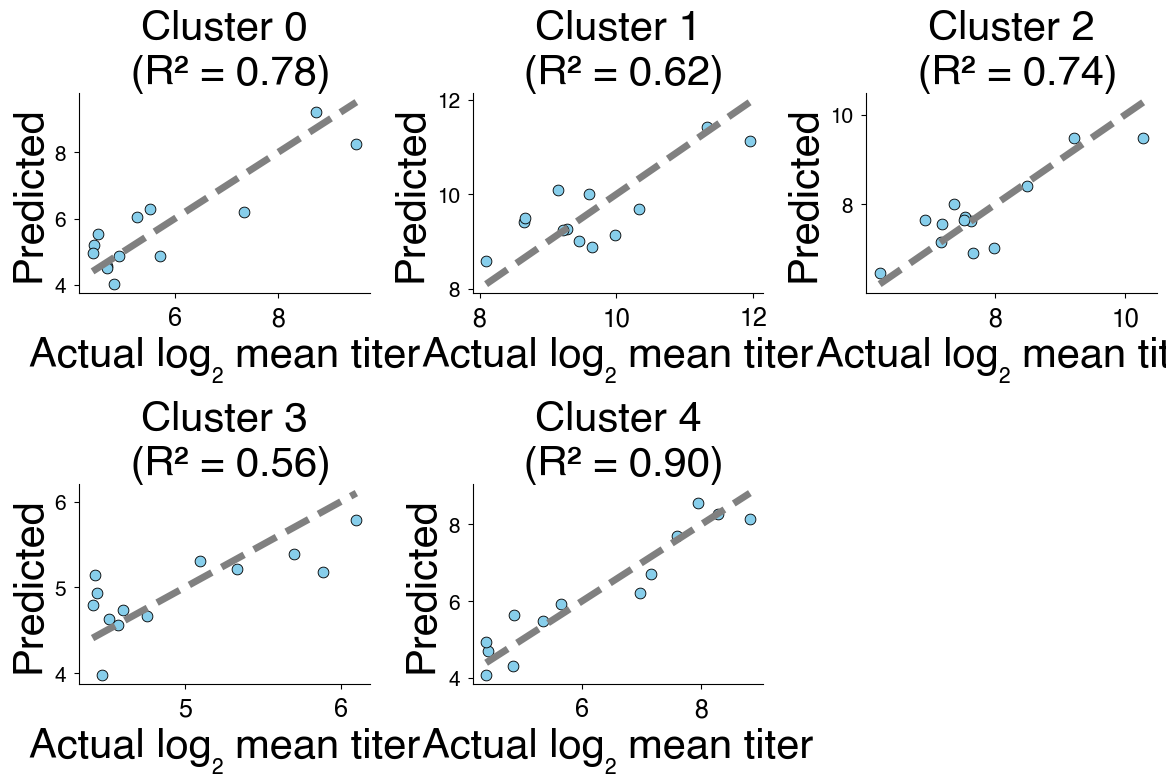

In [45]:
plot_groupwise_pred_vs_actual(results, eta_aligned, group_mean_matrix, group_names)

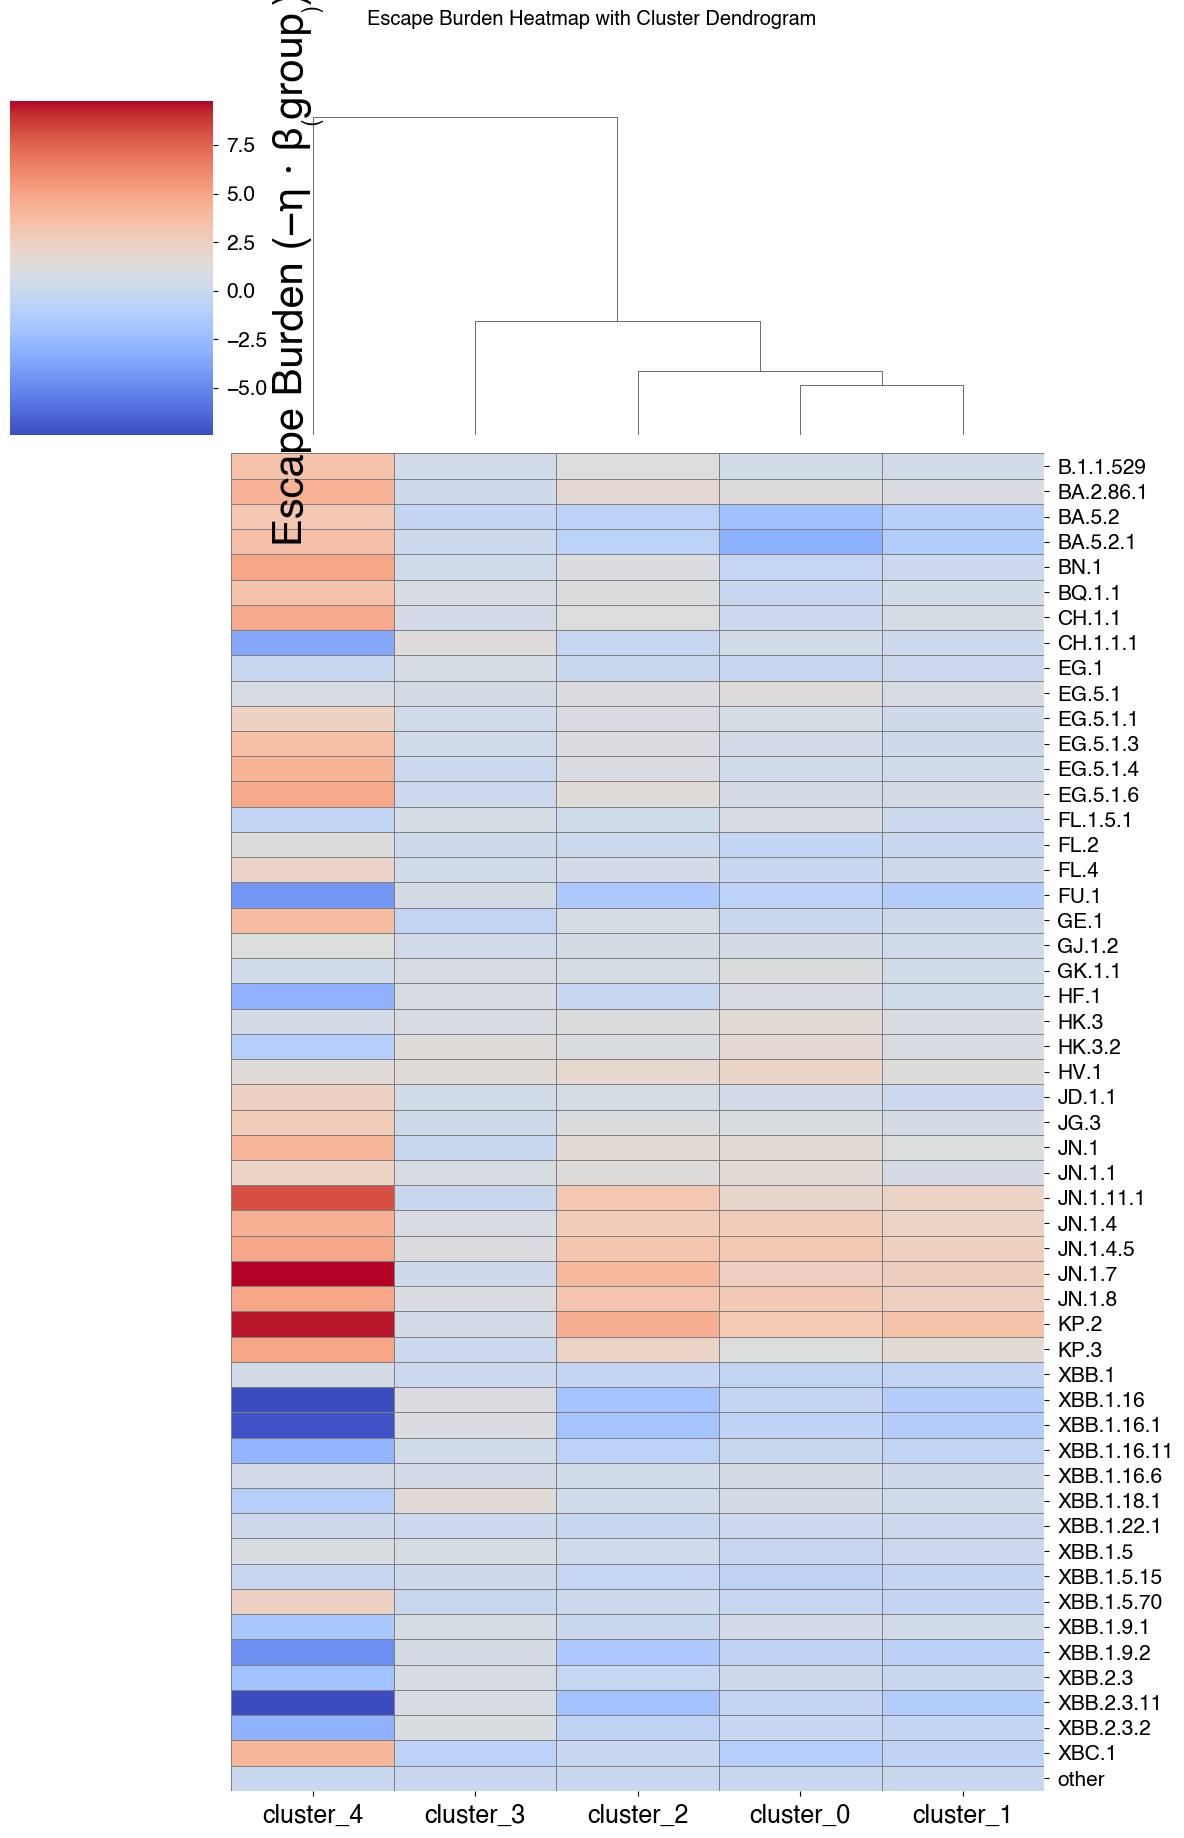

In [46]:
# Step 5: Escape burden
burden_df = compute_escape_burden(eta, variant_names, results)
plot_escape_burden_clustermap(burden_df)

In [47]:
def plot_cluster_to_group_heatmap(df, cluster_col="immune_cluster", group_col="group"):
    """
    Plots a heatmap of how many individuals in each (cluster, original group) pair.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    cooc_matrix = pd.crosstab(df[cluster_col], df[group_col])

    plt.figure(figsize=(12, 2 * max(6, 0.4 * cooc_matrix.shape[0])))
    sns.heatmap(cooc_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Co-occurrence of Immune Clusters and Original Immune History Groups")
    plt.xlabel("Original Immune Group")
    plt.ylabel("Unsupervised Immune Cluster")
    plt.tight_layout()
    plt.show()

    return cooc_matrix

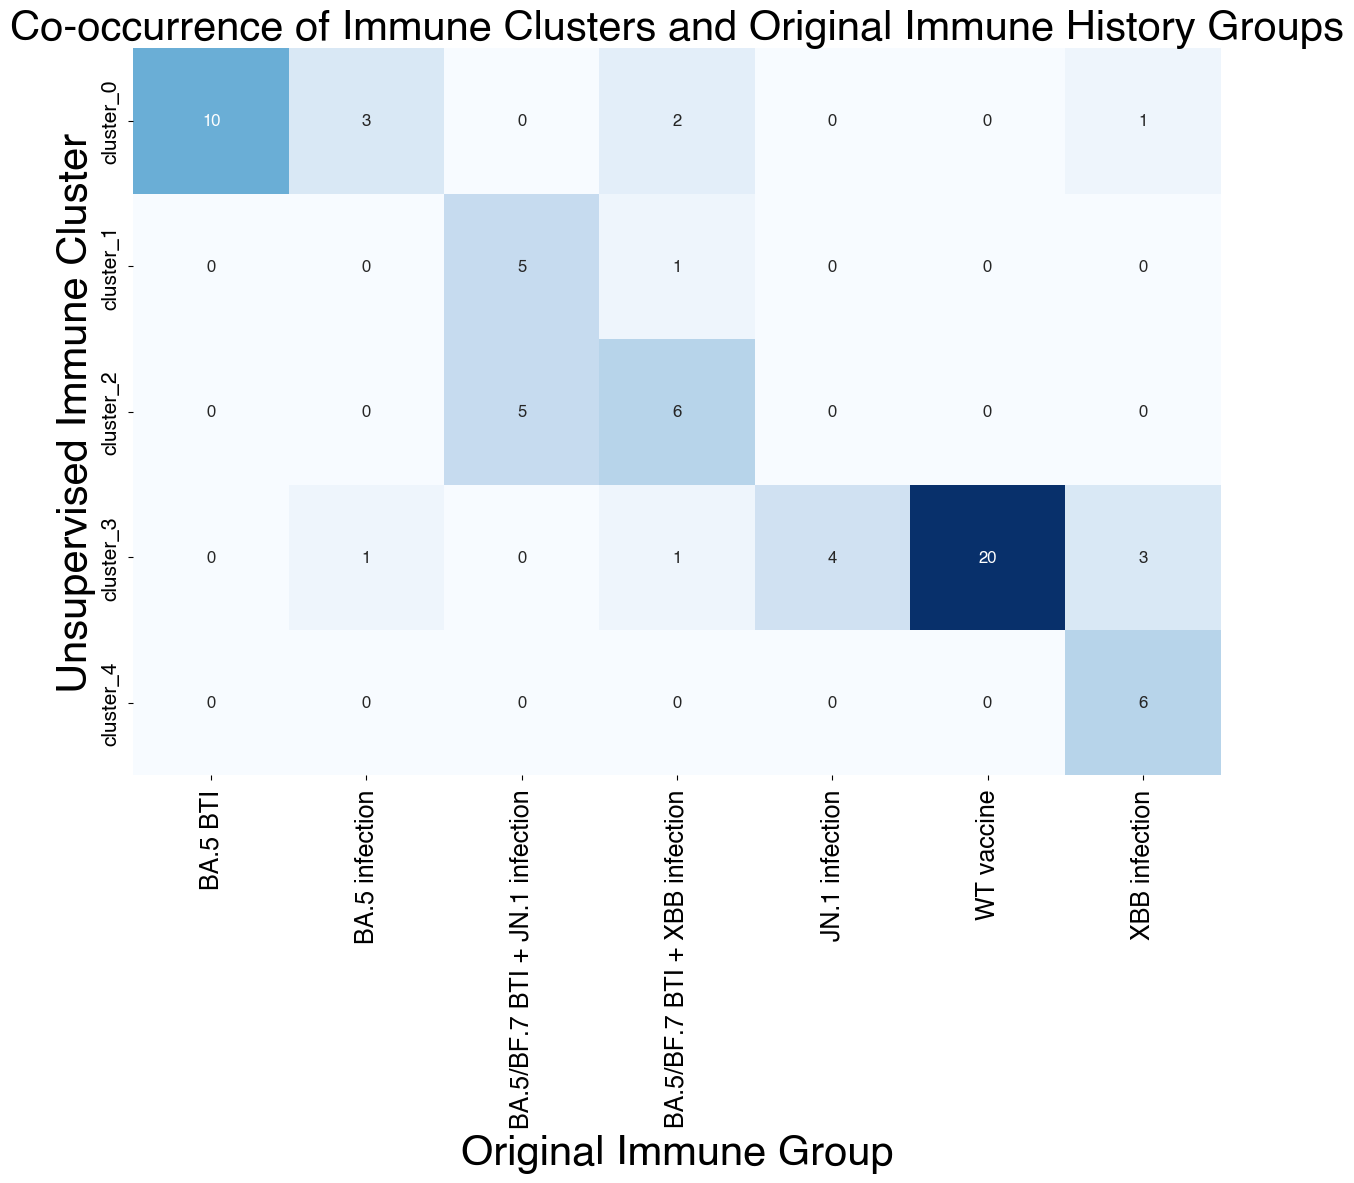

In [48]:
cooc_matrix = plot_cluster_to_group_heatmap(clustered_df)

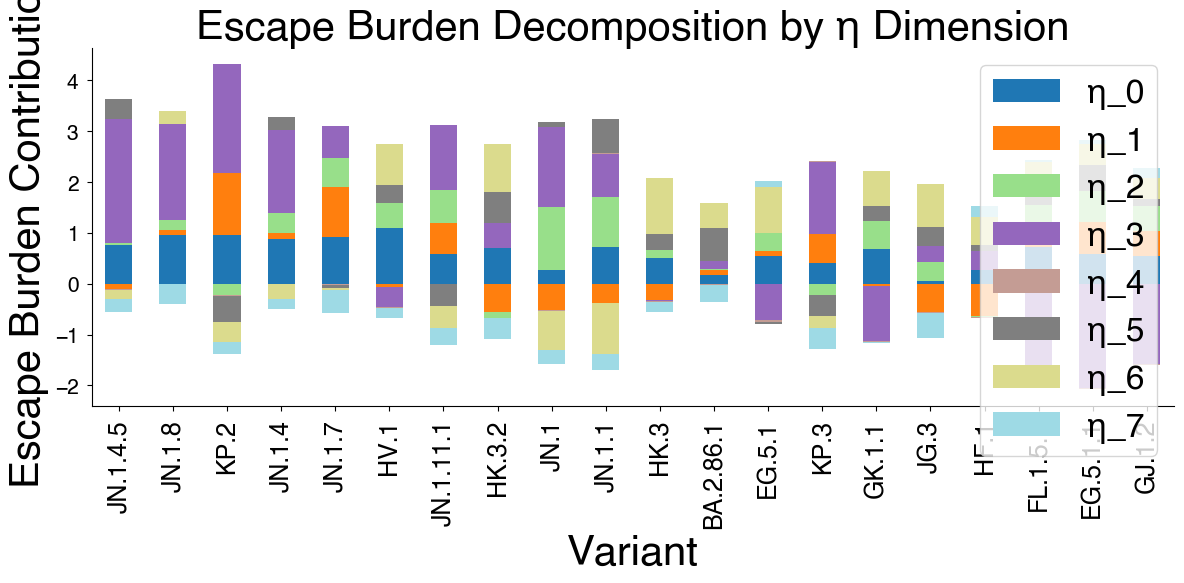

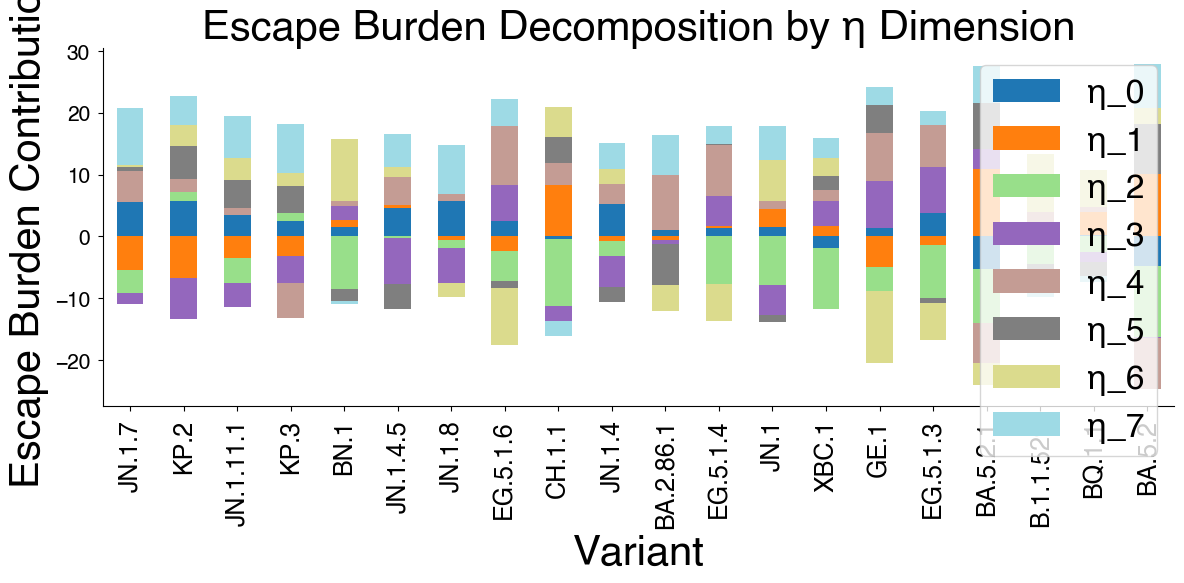

In [49]:
def compute_escape_burden_decomposition(eta, variant_names, results):
    """
    Returns a dict of group → DataFrame (rows = variants, columns = η dims)
    Each entry is the per-dimension contribution to escape burden.
    """
    group_contributions = {}
    for group, res in results.items():
        beta = res["coef"]  # shape: (latent_dims,)
        contrib_matrix = eta * (-beta)  # shape: (variants, dims)
        contrib_df = pd.DataFrame(
            contrib_matrix,
            index=variant_names,
            columns=[f"η_{i}" for i in range(eta.shape[1])]
        )
        group_contributions[group] = contrib_df
    return group_contributions

def plot_escape_burden_stackbar(group_contrib_df, top_n=10):
    """
    Stacked bar plot of per-η contribution to escape burden for top N variants
    """
    top_variants = group_contrib_df.sum(axis=1).nlargest(top_n).index
    subset = group_contrib_df.loc[top_variants]

    subset.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
    plt.title("Escape Burden Decomposition by η Dimension")
    plt.ylabel("Escape Burden Contribution")
    plt.xlabel("Variant")
    plt.tight_layout()
    plt.show()
    
# 1. Compute escape burden decomposition
group_contributions = compute_escape_burden_decomposition(eta, variant_names, results)

# 2. Plot stacked bar for a specific group
plot_escape_burden_stackbar(group_contributions["cluster_0"], top_n=20)
plot_escape_burden_stackbar(group_contributions["cluster_4"], top_n=20)

In [50]:
def plot_pca_dual_colorings(df, variant_names, cluster_col="immune_cluster", group_col="group"):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns

    variant_columns = [v for v in variant_names if v in df.columns]
    X = np.log2(df[variant_columns]).values

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pc_var = pca.explained_variance_ratio_ * 100  # as percent

    df_plot = df.copy()
    df_plot["PC1"] = X_pca[:, 0]
    df_plot["PC2"] = X_pca[:, 1]

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)

    sns.scatterplot(
        data=df_plot, x="PC1", y="PC2", hue=cluster_col,
        ax=axes[0], palette="tab10", edgecolor="k", s=80
    )
    axes[0].set_title("PCA Colored by Inferred Immune Clusters")
    axes[0].set_xlabel(f"PC1 ({pc_var[0]:.1f}% variance)")
    axes[0].set_ylabel(f"PC2 ({pc_var[1]:.1f}% variance)")
    axes[0].legend(title=cluster_col, bbox_to_anchor=(1.05, 1), loc="upper left")

    sns.scatterplot(
        data=df_plot, x="PC1", y="PC2", hue=group_col,
        ax=axes[1], palette="Set2", edgecolor="k", s=80
    )
    axes[1].set_title("PCA Colored by Original Immune Histories")
    axes[1].set_xlabel(f"PC1 ({pc_var[0]:.1f}% variance)")
    axes[1].set_ylabel("")  # optional: remove duplicate label
    axes[1].legend(title=group_col, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

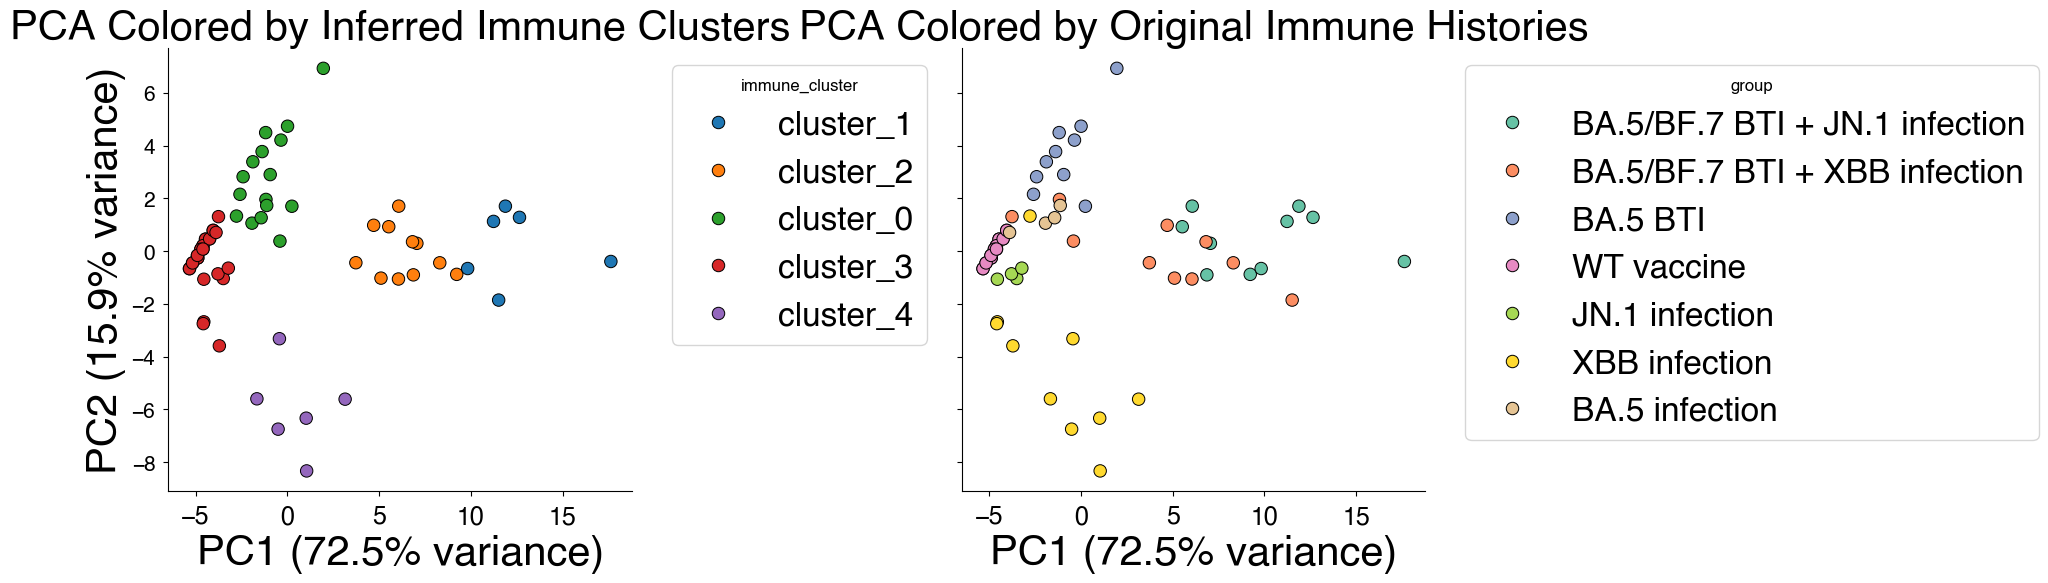

In [51]:
plot_pca_dual_colorings(clustered_df, variant_names)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1731/1286445979.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(groups, rotation=45, ha='right')


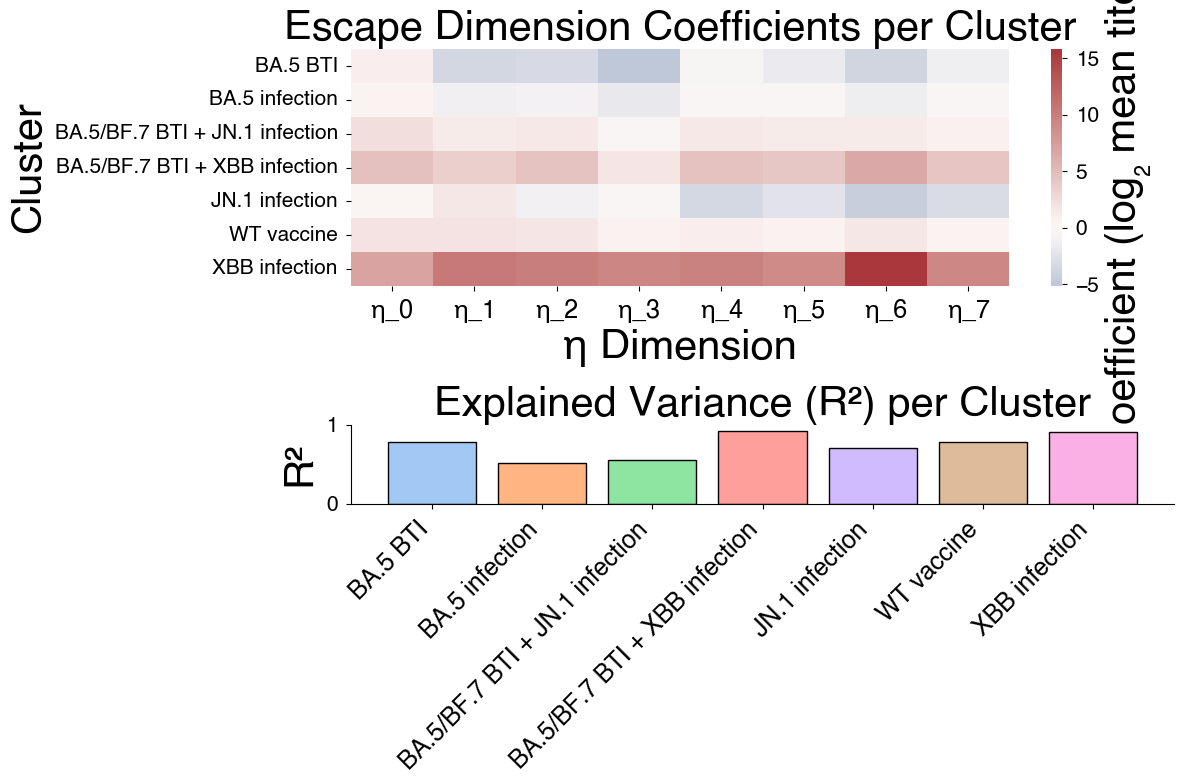

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1731/1286445979.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(groups, rotation=45, ha='right')


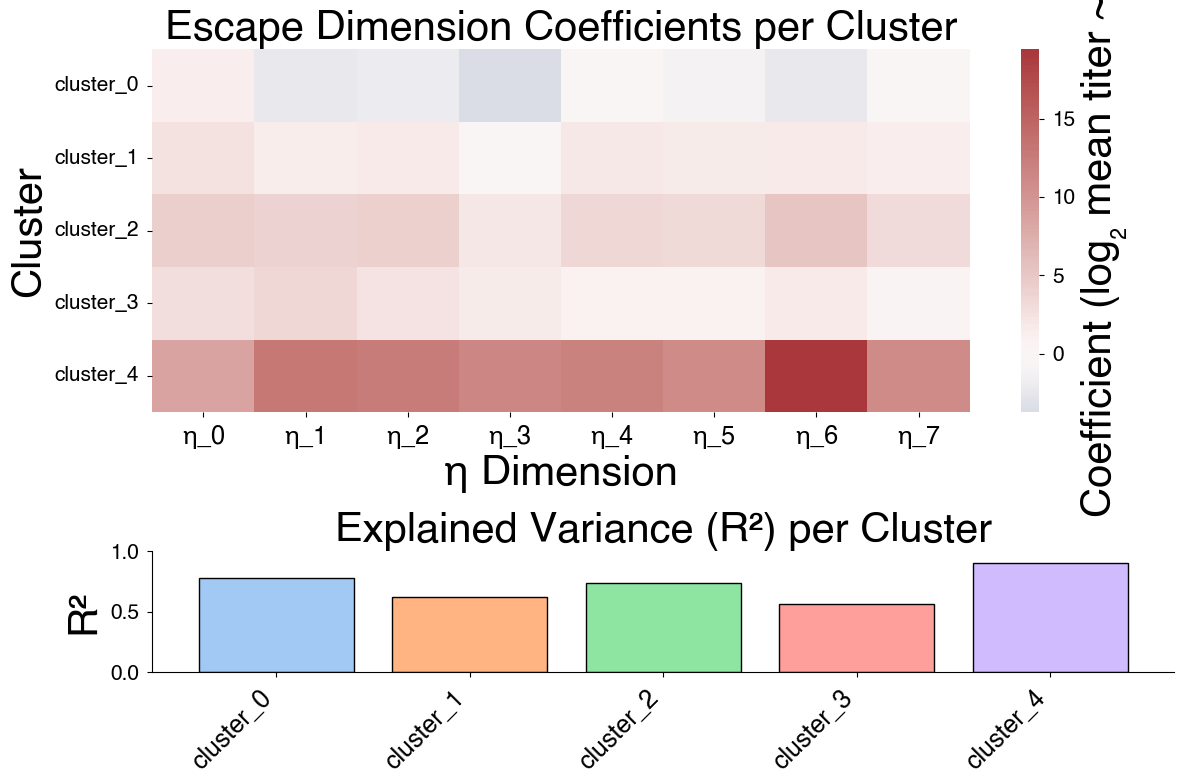

In [52]:
# Fit groupwise direction by infection group
group_mean_df_ig = compute_log2_group_mean_titers(antigenic_map, variant_names, group_col="group")
counts_df_ig      = compute_group_counts_matrix(clustered_df, variant_names,  group_col="group")

eta_aligned_ig, group_mean_matrix_ig, group_names_ig = align_eta_to_group_means(eta, variant_names, group_mean_df_ig)
results_infection_group = fit_groupwise_regression(eta_aligned_ig, group_mean_matrix_ig, group_names_ig, weights_matrix=counts_df_ig.values)

# Fit groupwise direction by learned clusters
group_mean_df_ic = compute_log2_group_mean_titers(clustered_df, variant_names, group_col="immune_cluster")
counts_df_ic      = compute_group_counts_matrix(clustered_df, variant_names,  group_col="immune_cluster")

eta_aligned_ic, group_mean_matrix_ic, group_names_ic = align_eta_to_group_means(eta, variant_names, group_mean_df_ic)
results_immune_cluster = fit_groupwise_regression(eta_aligned_ic, group_mean_matrix_ic, group_names_ic, weights_matrix=counts_df_ic.values)

# Visualizations
plot_groupwise_eta_interpretation(results_infection_group)
plot_groupwise_eta_interpretation(results_immune_cluster)

In [53]:
clade_definitions = [
    {
        "clade": "24B",
        "display_name": "24B (JN.1.11.1)",
        "defining_lineage": "JN.1.11.1",
        "color": '#DC2F24'
    },
    {
        "clade": "24A",
        "display_name": "24A (JN.1)",
        "defining_lineage": "JN.1",
        "color": '#E4632E'
    },
    {
        "clade": "23I",
        "display_name": "23I (BA.2.86)",
        "defining_lineage": "BA.2.86",
        "color": '#E69136'
    },
    {
        "clade": "23H",
        "display_name": "23H (HK.3)",
        "defining_lineage": "HK.3",
        "color": '#D9AD3D'
    },
    {
        "clade": "23G",
        "display_name": "23G (XBB.1.5.70)",
        "defining_lineage": "XBB.1.5.70",
        "color": '#C1BA47'
    },
    {
        "clade": "23F",
        "display_name": "23F (EG.5.1)",
        "defining_lineage": "EG.5.1",
        "color": '#A2BE57'
    },
    {
        "clade": "23E",
        "display_name": "23E (XBB.2.3)",
        "defining_lineage": "XBB.2.3",
        "color": '#83BA70'
    },
    {
        "clade": "23D",
        "display_name": "23D (XBB.1.9)",
        "defining_lineage": "XBB.1.9",
        "color": '#69B091'
    },
    {
        "clade": "23C",
        "display_name": "23C (CH.1.1)",
        "defining_lineage": "CH.1.1",
        "color": '#549DB2'
    },
    {
        "clade": "23B",
        "display_name": "23B (XBB.1.16)",
        "defining_lineage": "XBB.1.16",
        "color": '#4580CA'
    },
    {
        "clade": "23A",
        "display_name": "23A (XBB.1.5)",
        "defining_lineage": "XBB.1.5",
        "color": '#462EB9'
    },
    {
        "clade": "22F",
        "display_name": "22F (XBB)",
        "defining_lineage": "XBB",
        "color": '#3E58CF'
    },
    {
        "clade": "22E",
        "display_name": "22E (BQ.1)",
        "defining_lineage": "BQ.1",
        "color": '#777777'
    },
    {
        "clade": "22D",
        "display_name": "22D (BA.2.75)",
        "defining_lineage": "BA.2.75",
        "color": '#777777'
    },
    {
        "clade": "22B",
        "display_name": "22B (BA.5)",
        "defining_lineage": "BA.5",
        "color": '#777777'
    },
    {
        "clade": "other",
        "display_name": "other",
        "defining_lineage": False,
        "color": '#777777'
    }
]

In [54]:
from pango_aliasor.aliasor import Aliasor
import colorsys

DEFAULT_CLADE_COLOR = '#777777'
def order_lineages(lineages, aliasor):
    """
    Order input lineages by using their full uncompressed lineage & converting to a sortable form
    e.g. BA.5  -> B.1.1.529.5  -> '  B/001/001/529/005'
         BA.16 -> B.1.1.529.16 -> '  B/001/001/529/016'
         so BA.5 is before BA.16
    """
    def _lineage_sortable(lineage):
        if lineage=='other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i==0 else f"{int(x):03}") for i,x in enumerate(lin_full.split('.'))])
    return sorted(lineages,key=_lineage_sortable)

def order_lineages_within_clade(lineages, aliasor, clade_map):
    """
    Order input lineages by their clades first and then by using their full uncompressed lineage,
    converting to a sortable form within each clade.

    Parameters:
    lineages (list of str): List of lineage names to be sorted.
    aliasor (object): An object with a method `uncompress` that converts compressed lineage names to full lineage names.
    clades (list of str): List of clade assignments corresponding to each lineage.

    Returns:
    list of str: Sorted list of lineage names.

    Example:
    >>> class Aliasor:
    ...     def uncompress(self, lineage):
    ...         return {"BA.5": "B.1.1.529.5", "BA.16": "B.1.1.529.16", "BA.2": "B.1.1.529.2"}[lineage]
    >>> aliasor = Aliasor()
    >>> lineages = ["BA.5", "BA.16", "BA.2"]
    >>> clades = ["Clade1", "Clade1", "Clade2"]
    >>> order_lineages(lineages, aliasor, clades)
    ['BA.5', 'BA.16', 'BA.2']
    """

    def _lineage_sortable(lineage):
        if lineage == 'other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i == 0 else f"{int(x):03}") for i, x in enumerate(lin_full.split('.'))])
    
    # Sort the lineages first by clade and then by the sortable form of the lineage
    return sorted(lineages, key=lambda lineage: (clade_map[lineage], _lineage_sortable(lineage)))

def lineage_to_clade(lineage, aliasor, fallback, clade_definitions):
    lineage_full = aliasor.uncompress(lineage)
    for clade_data in clade_definitions:
        if clade_data['clade']=='other':
            continue
        comparison_lineage = aliasor.uncompress(clade_data['defining_lineage'])
        if lineage_full == comparison_lineage or lineage_full.startswith(comparison_lineage + "."):
            return clade_data['clade']
    return fallback

def clade_colors(variants, clade_definitions):
    colors = {c['clade']: c['color'] for c in clade_definitions}
    missing = set()
    defs = []
    for v in variants:
        try:
            defs.append([v, colors[v]])
        except KeyError:
            if v!='other':
                missing.add(v)
                defs.append([v, DEFAULT_CLADE_COLOR])

    # TODO: Emit this to output file so it can be sent thru Slack notifications
    if len(missing) > 0:
        print(
            f"Missing definitions for the following clades: {', '.join(missing)}.",
            f"They have been assigned the default color {DEFAULT_CLADE_COLOR!r}"
        )

    return defs

def clade_display_names(variants, clade_definitions):
    display_names = {c['clade']: c['display_name'] for c in clade_definitions}
    return [[name, display_names[name] if name in display_names else name]
            for name in variants]

def colour_range(anchor, n):
    """
    Create a range of `n` colours centred around the provided `anchor`.
    This currently involves simple manipulations in HLS space, but
    the outputs aren't going to be as good as they could be if we did it in
    a perceptually uniform space (e.g lab space). For the purposes of this viz
    I don't think it's a dealbreaker, and in our current setup it's hard to use
    python libraries which aren't already available in our various runtimes.
    """
    anchor_rgb = tuple(int(anchor.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    anchor_hls = colorsys.rgb_to_hls(*anchor_rgb)
    hrange = np.linspace(anchor_hls[0]*0.85, anchor_hls[0]*1.25, n)
    lrange = np.linspace(anchor_hls[1]*1.2, anchor_hls[1], n)
    srange = np.linspace(anchor_hls[2]*0.7, anchor_hls[2]*1.1, n)
    rgb_range = [colorsys.hls_to_rgb(*hls) for hls in zip(hrange, lrange, srange)]
    def clamp(x):
        return int(max(0, min(x, 255)))
    return [f"#{clamp(rgb[0]):02x}{clamp(rgb[1]):02x}{clamp(rgb[2]):02x}" for rgb in rgb_range]

def colourise(lineages, aliasor, clade_definitions):
    """
    Produces an array of arrays associating observed lineages with a colour hex. Example output:
        [
            ['XBB', '#ffffff'],
            ...
        ]
    """
    clades = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in lineages}

    colours = []

    for clade in list(set(clades.values())):
        matching_lineages = [l for l in lineages if clades[l]==clade] # will be ordered
        print(f"{clade:<10}n={len(matching_lineages)} lineages")
        color_hex = [x['color'] for x in clade_definitions if x['clade']==clade][0]
        for pair in zip(matching_lineages, colour_range(color_hex, len(matching_lineages))):
            colours.append(pair)
    return colours

aliasor = Aliasor()
color_map = colourise(posterior.data.var_names, aliasor, clade_definitions)
color_map = {entry[0]: entry[1] for entry in color_map}
clade_map = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in posterior.data.var_names}
clade_color_map = clade_colors([c["clade"] for c in clade_definitions], clade_definitions)
clade_color_map = {c[0]: c[1] for c in clade_color_map}

24A       n=6 lineages
23F       n=7 lineages
22D       n=1 lineages
23D       n=6 lineages
24B       n=3 lineages
22B       n=2 lineages
23A       n=3 lineages
23G       n=2 lineages
22E       n=1 lineages
23E       n=5 lineages
23B       n=6 lineages
23H       n=2 lineages
22F       n=3 lineages
other     n=3 lineages
23I       n=1 lineages
23C       n=2 lineages


In [55]:
def get_ordering(var_names):
    
    #reordered_names = order_lineages(var_names, aliasor)[:-1]
    reordered_names = order_lineages_within_clade(var_names, aliasor, clade_map)[:-1]
    reordered_clades = [clade_map[n] for n in reordered_names]

    reordered_idx = [var_names.index(r) for r in reordered_names]
    return reordered_idx, reordered_names, reordered_clades

def add_bracket(ax, start, end, label, y_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    y_offset : float, optional
        The vertical offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(start, y_offset), xytext=(end, y_offset),
                arrowprops=dict(arrowstyle='<|-|>', lw=2.0, **kwargs))
    ax.text((start + end) * 0.5, y_offset - height, label, fontsize=12, color=clade_color_map[label],
            ha='center', va='center', **kwargs)
    
def add_clade_dividers(ax, reordered_clades, height=-0.4, y_offset=4.5):
    current_clade = reordered_clades[0]
    start = 0

    for i in range(1, len(reordered_clades)):
        if reordered_clades[i] != current_clade:
            add_bracket(ax, start-0.5, i-.5, current_clade, y_offset=y_offset, height=height)
            current_clade = reordered_clades[i]
            start = i
            
    # Add bracket for the last group
    add_bracket(ax, start - 0.5, len(reordered_clades)-1 + 0.5, current_clade, y_offset=y_offset, height=height)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_1731/1166537408.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


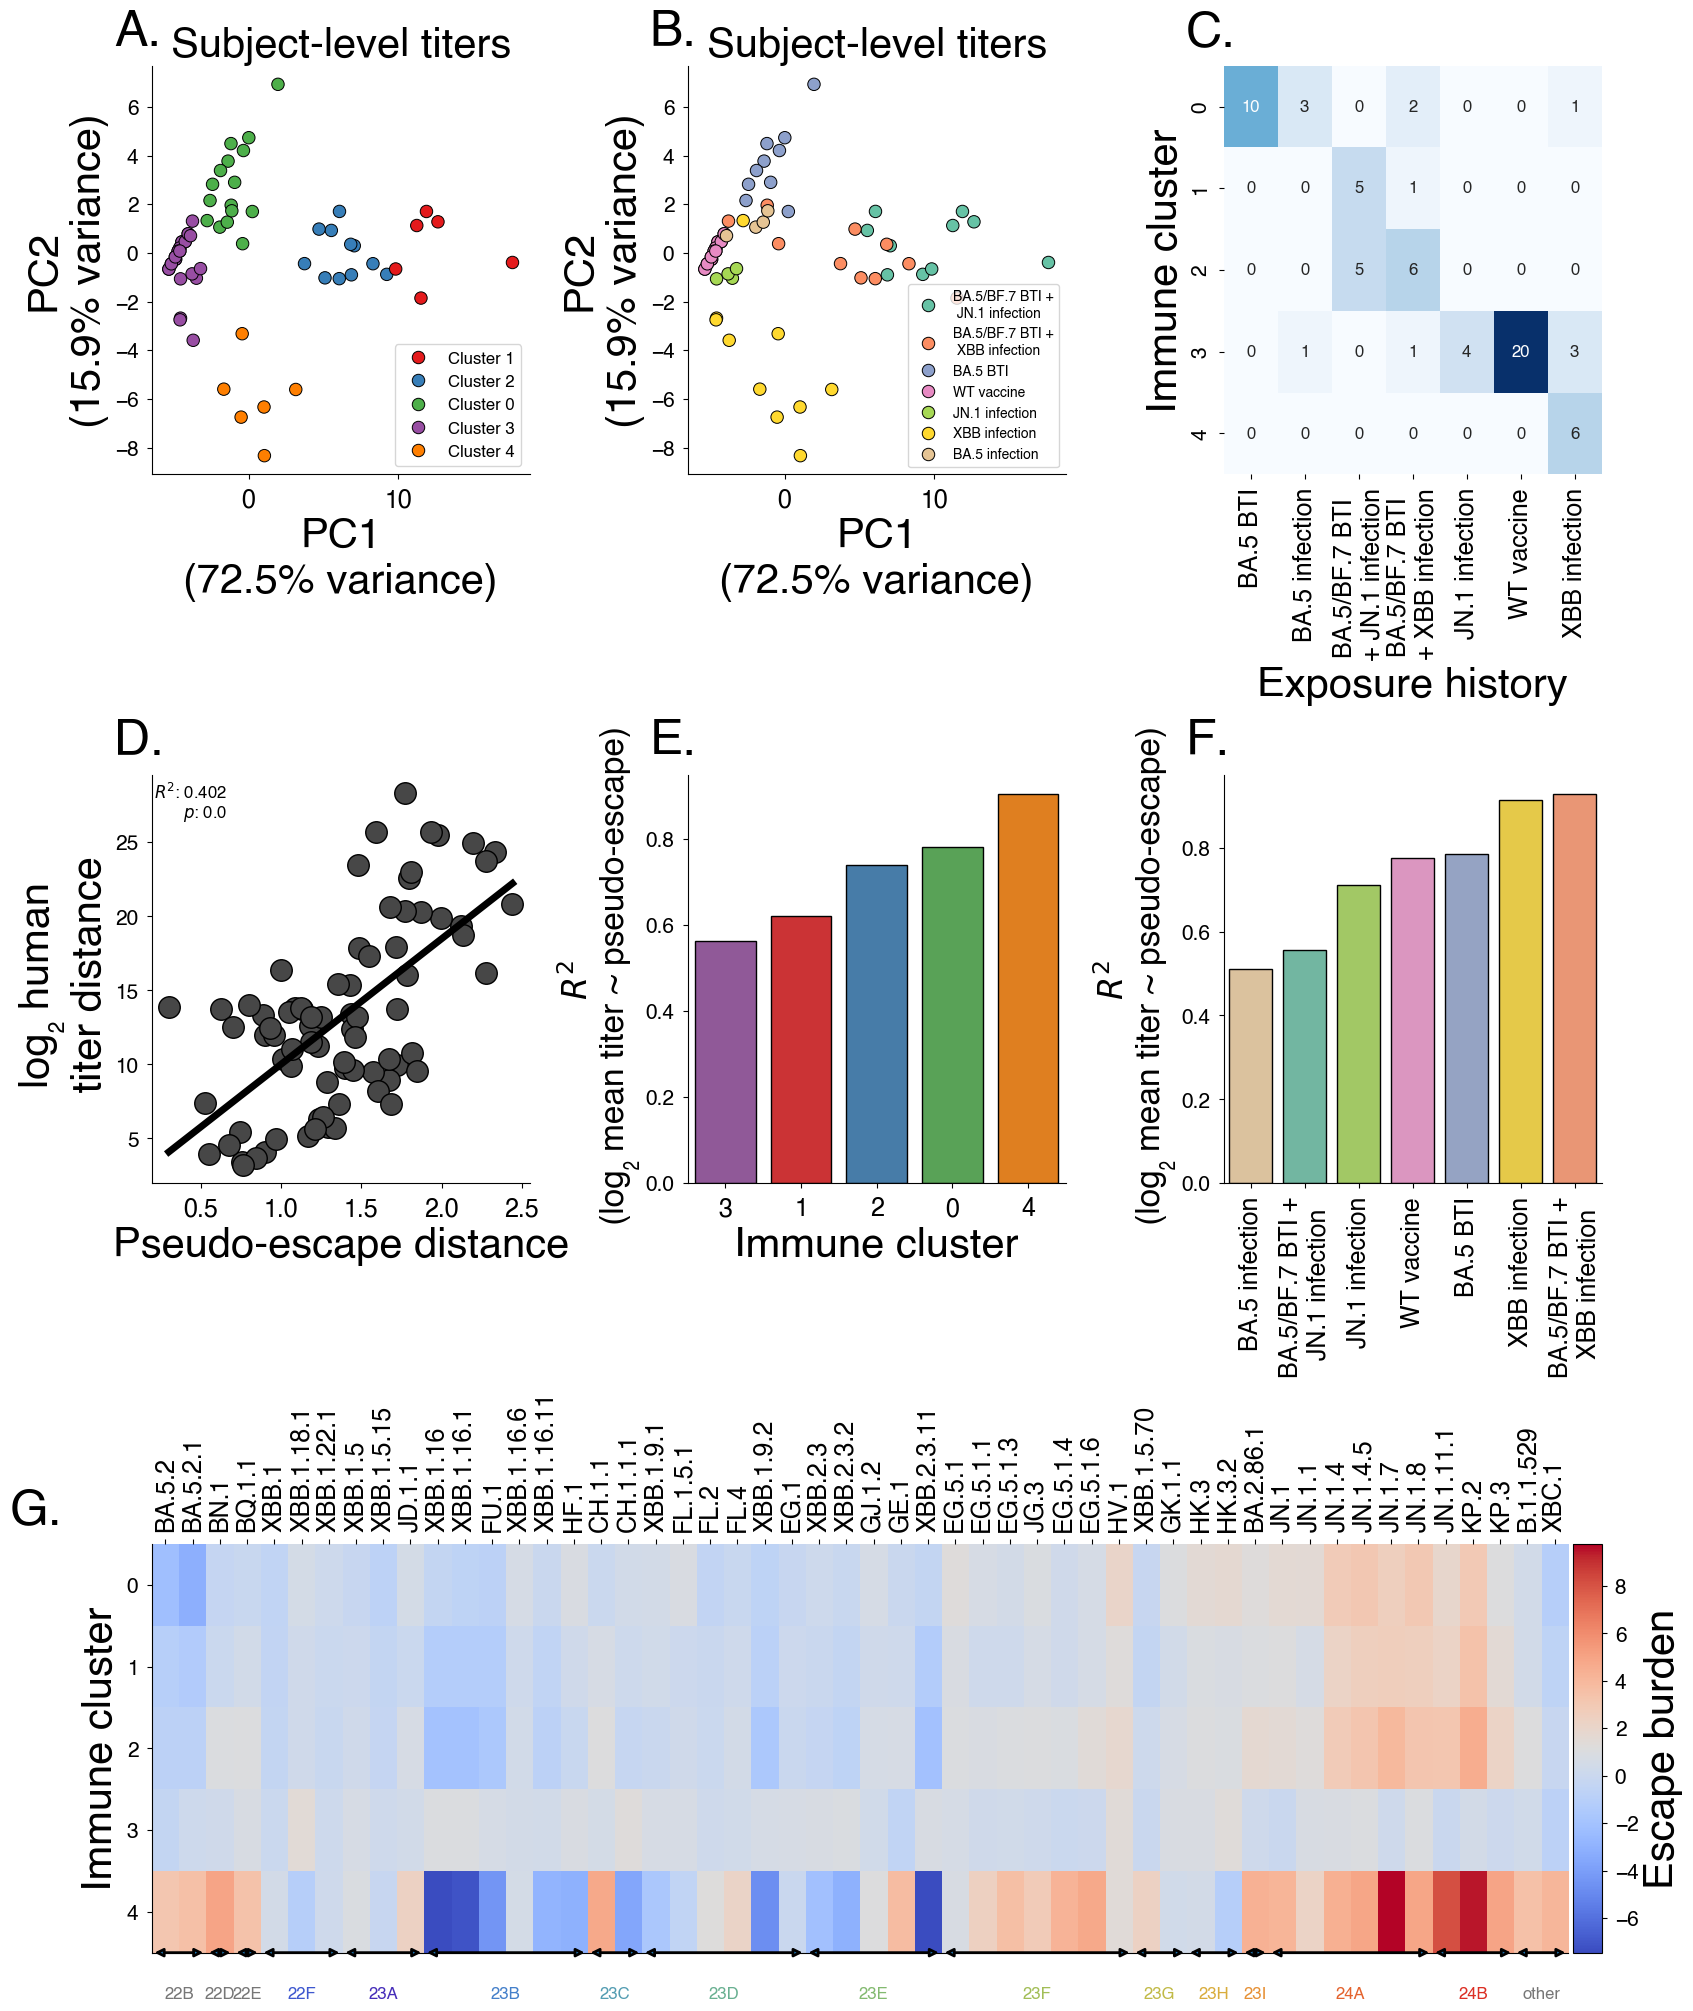

In [56]:
# Figure 6
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
    
def add_latent_distance(row, var_to_index, eta_distances):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

def immune_structure_plot(posterior, titer_df, distances_df, burden_df):
    
    fig = plt.figure(figsize=(16., 20.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=3, nrows=3, height_ratios=[1.0, 1.0, 1.0], width_ratios=[1.0, 1.0, 1.0])
    axes = []
    
    var_names = posterior.data.var_names

    # (D)
    ax = fig.add_subplot(spec[1,0])
    eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
    var_to_index = {v: i for i, v in enumerate(var_names)}        
    distances_df["latent_distance"] = distances_df.apply(lambda x: add_latent_distance(x, var_to_index, eta_distances), axis=1)

    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = distances_df[x_col], distances_df[y_col]
    ax.scatter(x, y, ec="k", color="#474747", s=240)      

    # Fit linear regression between two variables
    xs, ys, r, p = fit_linear(x_col, y_col)
    ax.plot(xs, ys, color="k")

    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))

    ax.text(0.2, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xlabel("Pseudo-escape distance")
    ax.set_ylabel("log₂ human \n titer distance")
    axes.append(ax)
    
    # (A) Subject Level Titers IC
    ax = fig.add_subplot(spec[0,0])
    variant_columns = [v for v in variant_names if v in titer_df.columns]
    X = np.log2(titer_df[variant_columns]).values

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pc_var = pca.explained_variance_ratio_ * 100  # as percent

    df_plot = titer_df.copy()
    df_plot["PC1"] = X_pca[:, 0]
    df_plot["PC2"] = X_pca[:, 1]
    df_plot["immune_cluster"] =df_plot["immune_cluster"].str.replace("cluster_", "Cluster ", regex=False)

    cluster_col="immune_cluster"
    sns.scatterplot(
        data=df_plot, x="PC1", y="PC2", hue=cluster_col,
        ax=ax, palette="Set1", edgecolor="k", s=80, legend=True
    )
    ax.set_title("Subject-level titers")
    ax.set_xlabel(f"PC1\n({pc_var[0]:.1f}% variance)")
    ax.set_ylabel(f"PC2\n({pc_var[1]:.1f}% variance)")
    ax.legend(loc="lower right", fontsize=12, frameon=True)
    handles, labels = ax.get_legend_handles_labels()
    cluster_color_map = {lab.strip("Cluster "): h.get_markerfacecolor() for lab, h in zip(labels, handles)}
    axes.append(ax)
    
    # (B) Subject Level Titers IG
    ax = fig.add_subplot(spec[0,1])
    df_plot["group"] =df_plot["group"].str.replace("+", "+\n", regex=False)

    cluster_col="group"
    sns.scatterplot(
        data=df_plot, x="PC1", y="PC2", hue=cluster_col,
        ax=ax, palette="Set2", edgecolor="k", s=80, legend=True
    )
    ax.set_title("Subject-level titers")
    ax.set_xlabel(f"PC1\n({pc_var[0]:.1f}% variance)")
    ax.set_ylabel(f"PC2\n({pc_var[1]:.1f}% variance)")
    ax.legend(loc="lower right", fontsize=10, frameon=True)
    handles, labels = ax.get_legend_handles_labels()
    group_color_map = {lab: h.get_markerfacecolor() for lab, h in zip(labels, handles)}
    axes.append(ax)
    
    # (G) Strong escape
    ax = fig.add_subplot(spec[2,:])
    
    # Get ordering and clades with pango_aliasor
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)

    _burden_df = burden_df.copy()
    _burden_df = _burden_df[_burden_df.index != "other"].reindex(reordered_names)
    _burden_df.columns = _burden_df.columns.str.strip("cluster_")

    im = ax.matshow(_burden_df.T, cmap="coolwarm", aspect='auto')
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks(np.arange(len(_burden_df.index)))
    
    ax.set_xticks(np.arange(len(var_names)-1))
    xticklabels_reordered = [var_names[:-1][r] for r in reordered_idx]
    ax.set_xticklabels(xticklabels_reordered, rotation=90)
    ax.tick_params(axis='x', bottom=False)
    
    divider = make_axes_locatable(ax)
    add_clade_dividers(ax, reordered_clades, height=-0.5, y_offset=5-0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label='Escape burden')    

    ax.set_ylabel("Immune cluster")
    axes.append(ax)
    
    # (E)
    ax = fig.add_subplot(spec[1,1])
    df_plot = pd.DataFrame({"clusters": [g.strip("cluster_") for g in group_names_ic], "r2": [results_immune_cluster[group]['r2'] for group in group_names_ic]})
    order = df_plot.groupby("clusters")["r2"].mean().sort_values(ascending=True).index
    sns.barplot(data=df_plot, x="clusters", y="r2", palette=cluster_color_map, hue="clusters", ec="k", ax=ax, order=order)
    ax.set_xlabel("Immune cluster")
    ax.set_ylabel("$R^2$\n (log₂ mean titer ~ pseudo-escape)", fontsize=24)
    axes.append(ax)
    
    # (F)
    ax = fig.add_subplot(spec[1,2])
    df_plot = pd.DataFrame({"clusters": [g.replace("+", "+\n") for g in group_names_ig], "r2": [results_infection_group[group]['r2'] for group in group_names_ig]})
    order = df_plot.groupby("clusters")["r2"].mean().sort_values(ascending=True).index
    sns.barplot(data=df_plot, x="clusters", y="r2", palette=group_color_map,hue="clusters", ec="k", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("$R^2$\n (log₂ mean titer ~ pseudo-escape)", fontsize=24)
    axes.append(ax)

    
    # (C)
    ax = fig.add_subplot(spec[0,2])
    cluster_col="immune_cluster"
    group_col="group"
    
    _titer_df = titer_df.copy()
    _titer_df[group_col] = _titer_df[group_col].str.replace("+", "\n+", regex=False)
    _titer_df[cluster_col] = _titer_df[cluster_col].str.strip("cluster_")
    cooc_matrix = pd.crosstab(_titer_df[cluster_col], _titer_df[group_col])
    sns.heatmap(cooc_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)   
    ax.set_xlabel("Exposure history")
    ax.set_ylabel("Immune cluster")
    axes.append(ax)

    # Add labels
    ax_labels = ["D", "A", "B", "G", "E", "F", "C"] 

    for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    return fig


fig_immune_structure = immune_structure_plot(posterior,clustered_df, distances_df, burden_df)
fig_immune_structure.savefig("../manuscript/figures/latent-immune-structure.png")

In [57]:
burden_df.index == variant_names

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

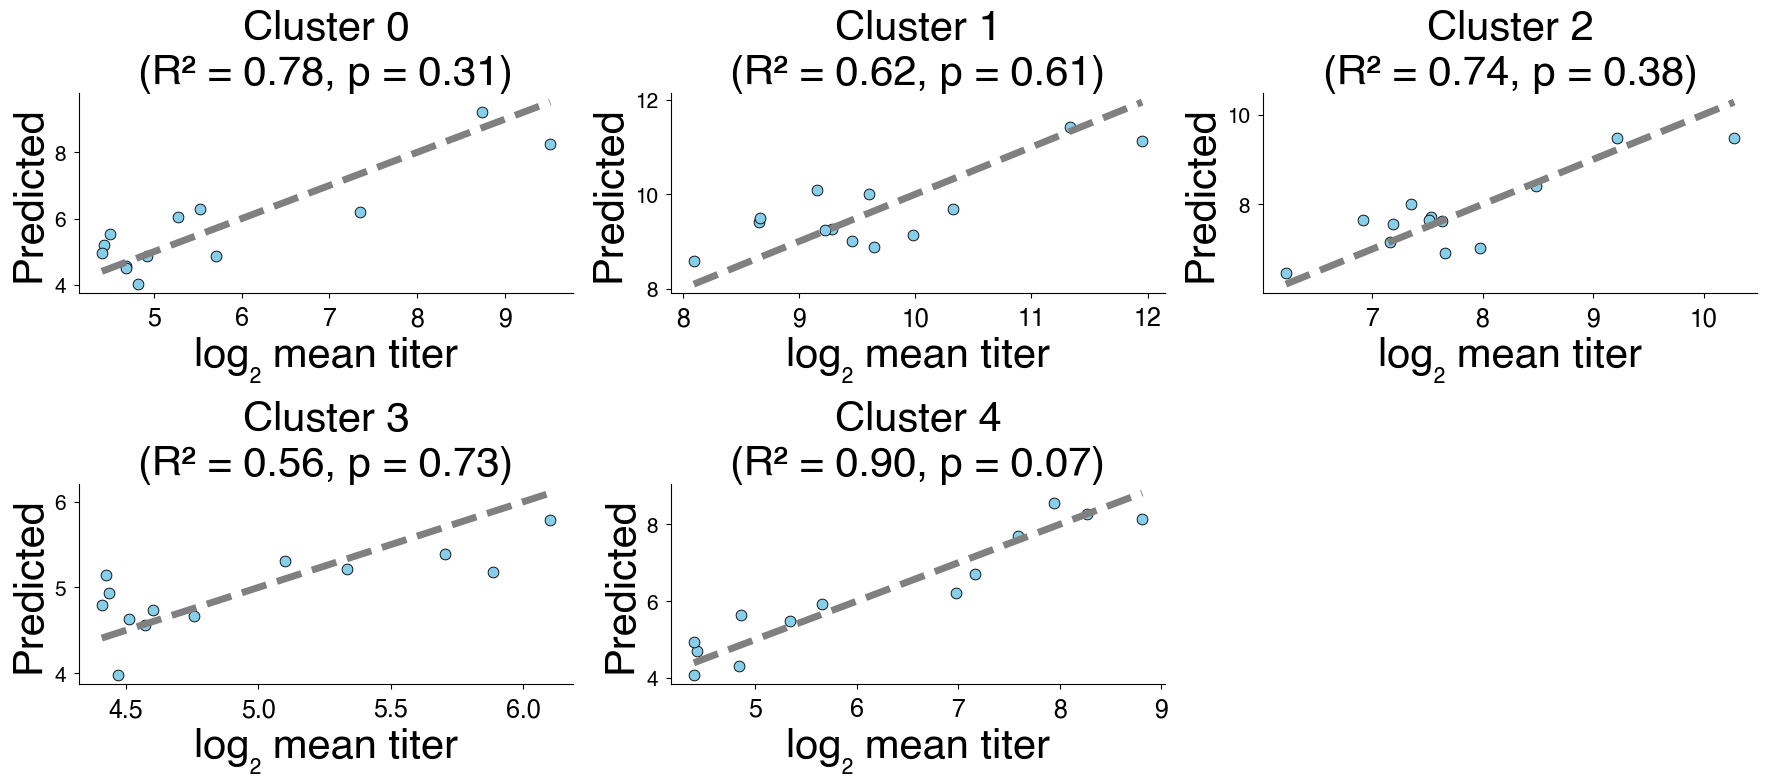

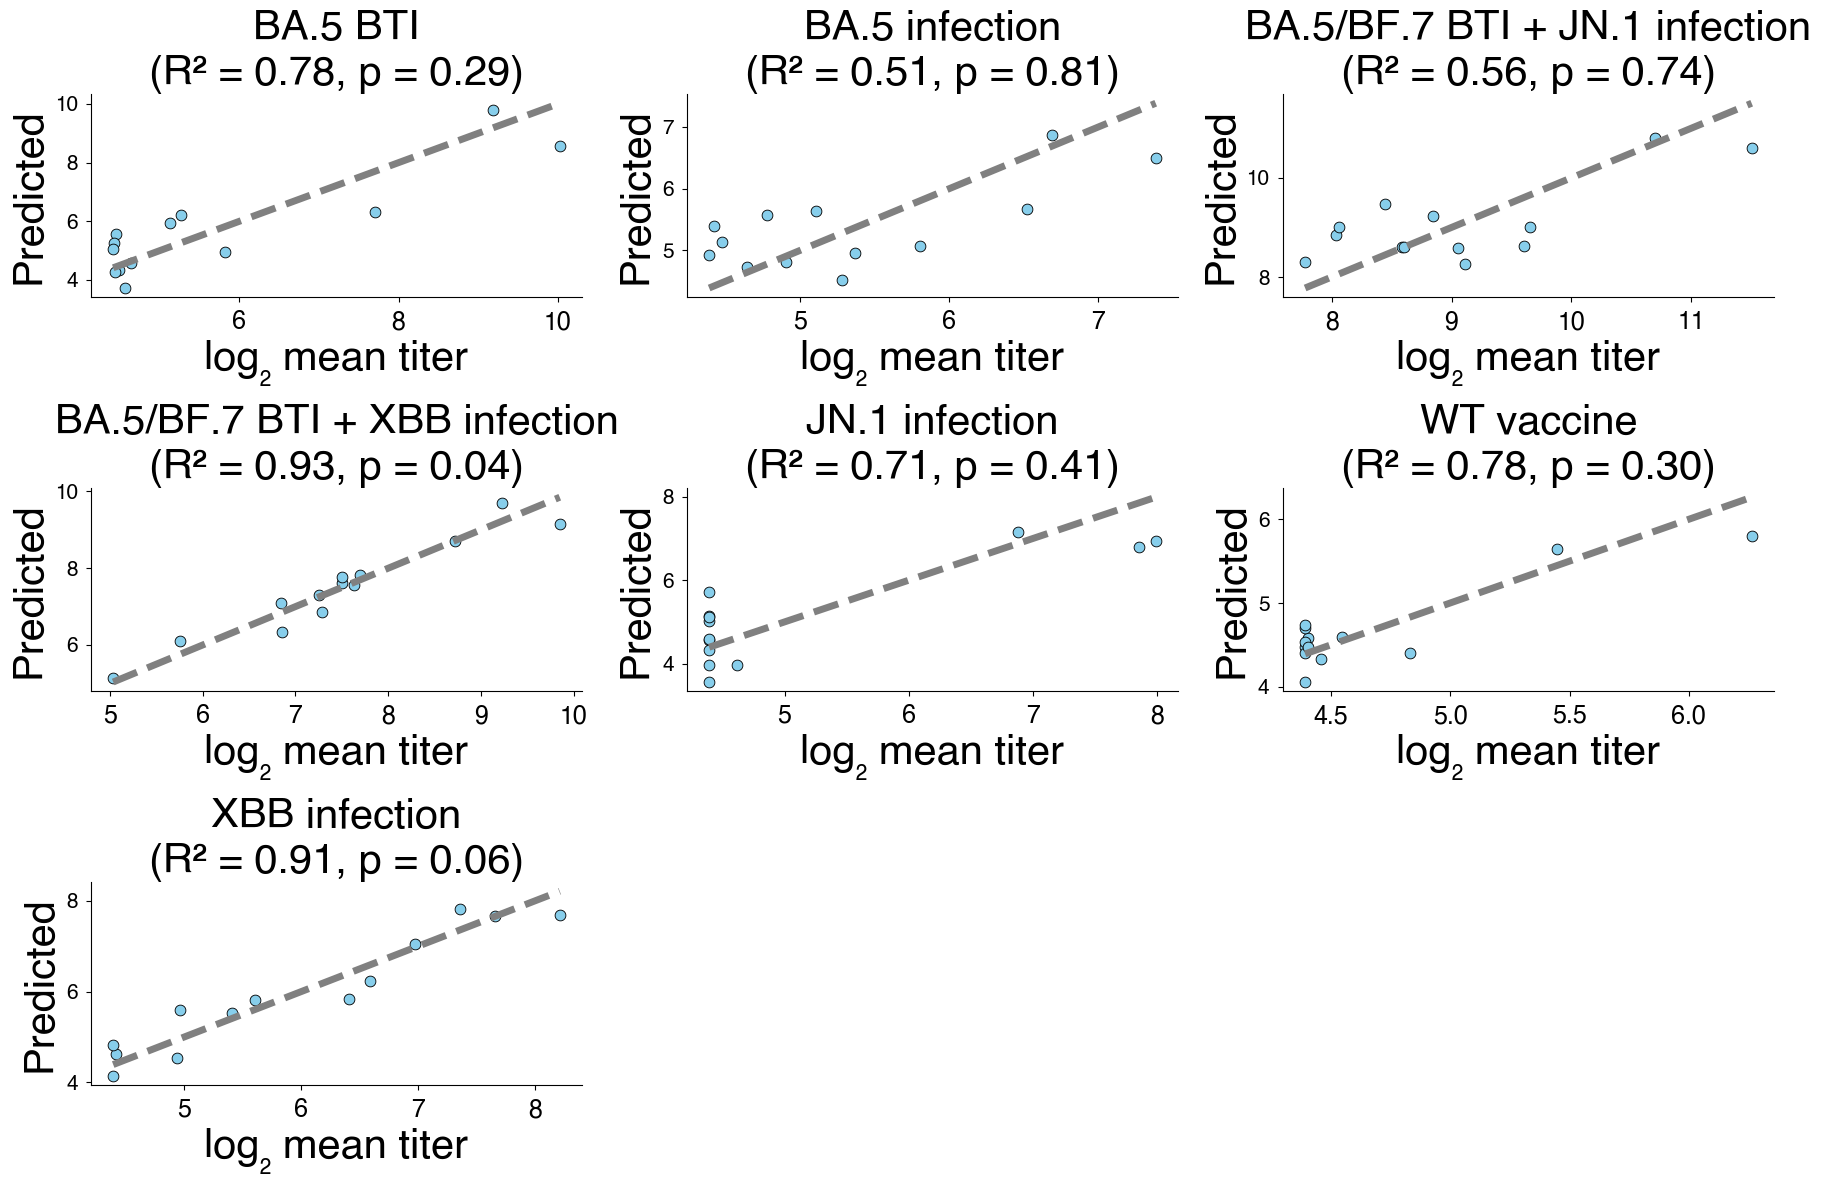

In [58]:
# Do with no clustering to show overall correlation between titers and eta (6th panel)
def plot_groupwise_pred_vs_actual(results, eta_aligned, group_mean_matrix, group_names, ncols=3, size_per_panel=(4,4)):
    """
    Small multiples of actual vs predicted log2 mean titers per group.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    n_groups = len(group_names)
    nrows = math.ceil(n_groups / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(size_per_panel[0] * ncols, size_per_panel[1] * nrows), squeeze=False)

    for idx, group in enumerate(group_names):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]

        y_true = group_mean_matrix[:, idx]
        model = results[group]
        y_pred = eta_aligned @ model["coef"] + model["intercept"]

        sns.scatterplot(x=y_true, y=y_pred, ax=ax, color="skyblue", edgecolor="k", s=60)
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray')
        ax.set_title(f"{group.replace('cluster_', 'Cluster ')}\n (R² = {results[group]['r2']:.2f})")
        ax.set_xlabel("log₂ mean titer")
        ax.set_ylabel("Predicted")
        
    # Turn off unused subplots
    for i in range(n_groups, nrows * ncols):
        row, col = divmod(i, ncols)
        axes[row][col].axis('off')

    plt.tight_layout()
    return fig

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_groupwise_pred_vs_actual(
    results, eta_aligned, group_mean_matrix, group_names, 
    n_perms=1000, ncols=3, size_per_panel=(4,4), random_state=53
):
    """
    Small multiples of actual vs predicted log2 mean titers per group
    with permutation-based p-values using sklearn LinearRegression.
    """
    rng = np.random.default_rng(random_state)

    n_groups = len(group_names)
    nrows = math.ceil(n_groups / ncols)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(size_per_panel[0] * ncols, size_per_panel[1] * nrows),
        squeeze=False
    )

    for idx, group in enumerate(group_names):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]

        y_true = group_mean_matrix[:, idx]
        model = results[group]
        y_pred = eta_aligned @ model["coef"] + model["intercept"]
        r2_obs = results[group]['r2']

        # Permutation null using sklearn
        r2_null = np.empty(n_perms)
        for p in range(n_perms):
            y_perm = rng.permutation(y_true)
            perm_model = LinearRegression().fit(eta_aligned, y_perm)
            r2_null[p] = perm_model.score(eta_aligned, y_perm)

        # p-value = proportion of null R² >= observed
        p_val = (np.sum(r2_null >= r2_obs) + 1) / (n_perms + 1)

        sns.scatterplot(
            x=y_true, y=y_pred, ax=ax,
            color="skyblue", edgecolor="k", s=60
        )
        ax.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--', color='gray'
        )
        ax.set_title(
            f"{group.replace('cluster_', 'Cluster ')}\n"
            f"(R² = {r2_obs:.2f}, p = {p_val:.2f})"
        )
        ax.set_xlabel("log₂ mean titer")
        ax.set_ylabel("Predicted")
        
    # Turn off unused subplots
    for i in range(n_groups, nrows * ncols):
        row, col = divmod(i, ncols)
        axes[row][col].axis('off')

    plt.tight_layout()
    return fig

# Turn this to supplementary figure
fig_ic = plot_groupwise_pred_vs_actual(results_immune_cluster, eta_aligned_ic, group_mean_matrix_ic, group_names_ic, size_per_panel=(6,4))
fig_ig = plot_groupwise_pred_vs_actual(results_infection_group, eta_aligned_ig, group_mean_matrix_ig, group_names_ig, size_per_panel=(6,4))

fig_ic.savefig("../manuscript/supplementary_figures/groupwise_titer_correlation_immune_cluster.png")
fig_ig.savefig("../manuscript/supplementary_figures/groupwise_titer_correlation_immune_group.png")